# Do Microfinance Institutions Prioritise Need? Evidence from Loan Allocation and Repeat Borrowing Patterns

# Project 1

## 1.1. Introduction

Microfinance is widely promoted as a mechanism to promote financial inclusion by extending small scale credit to individuals excluded from traditional banking systems. Hermes and Lensink (2011) argue that microfinance institutions play an important role in expanding access to financial services for those excluded from formal financial markets. These loans are intended to support entrepreneurship, reduce poverty, and foster economic mobility in underserved communities. However, two central questions remain unresolved: To what extent are microfinance loans allocated based on borrower financial need, and do these loans promote economic growth or reinforce financial dependency over time?

This paper investigates both aspects by analysing how microfinance loan amounts relate to indicators of borrower vulnerability, and how loan sizes evolve as borrowers return for subsequent financing. The first part of the analysis explores whether more financially vulnerable borrowers, those facing higher poverty levels or expressing greater financial need through their loan descriptions, receive larger loans. A study by Domanban, P. B. (2023) suggests that more vulnerable borrowers, characterised by larger households and potentially lower incomes, may receive smaller loans. The second part examines whether repeated borrowing is associated with loan growth, suggesting upward mobility, or whether loan sizes remain stagnant or decline, potentially indicating borrower dependence or cautious institutional lending. Field et al. (2013) show that rigid microfinance structures can sometimes discourage entrepreneurial expansion, raising questions about whether repeated borrowing fosters growth or maintains dependence.

To address these questions, we use a pooled cross sectional dataset from Kiva.org, a global microfinance platform facilitating peer-to-peer lending. The dataset includes loan level observations from 2006 to 2017 across dozens of countries, with information on borrower demographics, loan characteristics, geographic coordinates, and loan narratives. Using this data, we estimate a series of regression models to evaluate the effect of textually expressed need, and loan sequence, on loan size. We estimate determinants of loan size, incorporating borrower level controls (gender, sentiment, borrower count, etc), loan level controls (term, number of lenders, funding speed, etc), and fixed effects for country, sector, and year.

Financial need is measured using two main indicators. The first is a Need Score derived from the loan narrative: a large language model (LLM) is used to classify a sample of loan descriptions based on expressed financial hardship, and this labeled subset is used to train a logistic regression model that classifies the remaining loans. Recent studies have demonstrated the efficacy of LLMs, such as BERT, in analysing textual data to assess financial risk. For instance, Sanz-Guerrero and Arroyo (2024) utilised LLMs to process loan descriptions and assign risk scores, highlighting the potential of these models in evaluating borrower information. The second is the Multidimensional Poverty Index (MPI) of the borrower’s region, which captures area-level deprivation. The MPI is a widely recognised measure that captures multiple deprivations experienced by individuals in health, education, and standard of living. Developed by Alkire and Santos (2010), it provides a comprehensive assessment of regional poverty. While both indicators are used separately in the analysis, they provide complementary perspective, one reflecting localised poverty, the other individualised need as expressed by the borrower.

Finally, to understand whether borrowers are growing or becoming reliant over time, we analyse sequential borrowing patterns. By following individual borrowers across multiple loans, we assess whether loan sizes increase, suggesting business expansion and financial progress, or whether they plateau or shrink, potentially signaling borrower dependence or more cautious institutional lending. This second component transforms the dataset from pooled cross sectional loan level data into panel borrower level data, allowing us to control for borrower specific fixed effects and isolate within borrower dynamics. This approach expands on prior work by Banerjee et al. (2015), who find that repeat microfinance borrowers tend to increase their loan amounts over time, with some evidence of business growth, but limited improvements in household income and consumption. While their study focuses on a randomised intervention in one city, our analysis broadens this investigation to a global sample and incorporates measures of expressed financial need and comparing loan trajectories across need classifications.

Together, these analyses offer a comprehensive overview of how microfinance institutions allocate capital and whether they fulfill their stated mission of enabling upward mobility for the financially underserved.

## 1.2. Data Cleaning & Loading

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# File Paths
data_path = "/Users/jakubriha/Desktop/ECO225/Project/Data/"
files = {
    "loans": "loans.csv", "coords": "loan_coords.csv",
    "mpi": "kiva_mpi_region_locations.csv", "gdp": "imf-dm-export-20250308.csv"
}

# Load Data
df = pd.read_csv(data_path + files["loans"]).merge(
    pd.read_csv(data_path + files["coords"]), on='loan_id')

df_gdp = pd.read_csv(data_path + files["gdp"]).melt(
    id_vars=['Country'], value_vars=[str(y) for y in range(2005, 2018)],
    var_name='year', value_name='gdp_per_capita'
).astype({'year': int})

df['year'] = pd.to_datetime(df['posted_time']).dt.year
df = df.merge(df_gdp, left_on=['country_name', 'year'], right_on=['Country', 'year'], how='left')

In [5]:
# Drop missing GDP values and redundant columns
df.dropna(subset=['gdp_per_capita'], inplace=True)
df.drop(columns=['Country'], inplace=True)

# Load MPI Data
df_mpi = pd.read_csv(data_path + files["mpi"]).dropna(subset=['lat', 'lon'])
df = df[df['country_name'].isin(df_mpi['country'].unique())]

# Nearest-Neighbor Matching (KDTree)
df[['nearest_mpi_region', 'nearest_mpi_country']] = pd.NA
df['nearest_mpi_value'] = np.nan

for country in df['country_name'].unique():
    loans_sub, mpi_sub = df[df['country_name'] == country], df_mpi[df_mpi['country'] == country]
    if mpi_sub.empty: continue
    
    tree = cKDTree(mpi_sub[['lon', 'lat']].to_numpy())
    distances, indices = tree.query(loans_sub[['longitude', 'latitude']].to_numpy())
    nearest = mpi_sub.iloc[indices]
    
    df.loc[loans_sub.index, ['nearest_mpi_region', 'nearest_mpi_country', 'nearest_mpi_value']] = (
        nearest[['region', 'country', 'MPI']].values
    )

from sklearn.preprocessing import StandardScaler

df['mpi_standardised'] = StandardScaler().fit_transform(df[['nearest_mpi_value']])

# Gender Processing
df['borrower_genders'] = df['borrower_genders'].astype(str).fillna("Unknown")
df['gender_list'] = df['borrower_genders'].apply(lambda x: set(x.split(', ')))
df['female'] = df['gender_list'].apply(lambda x: 1 if x == {'female'} else 0)
df['mixed_gender'] = df['gender_list'].apply(lambda x: 1 if {'female', 'male'}.issubset(x) else 0)
df.drop(columns=['gender_list'], inplace=True)

# Financial & Text Processing
df['gdp_per_capita'] = df['gdp_per_capita'].replace(',', '', regex=True).astype(float)
df['borrower_count'] = df['borrower_genders'].apply(lambda x: len(str(x).split(', ')))
df['loan_amount_adj'] = df['loan_amount'] / df['borrower_count']
df['loan_to_income'] = df['loan_amount'] / df['gdp_per_capita']
df['loan_to_income_adj'] = df['loan_amount_adj'] / df['gdp_per_capita']

df['borrower_pictured'] = df['borrower_pictured'].str.lower().map({'true': 1, 'false': 0})
df['text'] = df['description_translated'].fillna(df['description']).str.lower()
df.dropna(subset=['text'], inplace=True)

In [11]:
import openai
import time
import random
from openai import OpenAI

client = OpenAI(api_key="Enter your key"

# Sample 2000 descriptions from the DataFrame
sample_df = df[['loan_id', 'text']].dropna().sample(2000, random_state=42).copy()

# Prompt builder
def build_prompt(text):
    return f"""
You are an expert in microfinance. Your task is to classify the financial need expressed in a microloan request.

A 'High Need' loan is one where the borrower appears to lack the financial resources to achieve their goal — whether that goal is essential (like food or shelter) or economic (like starting a small business). Indicators include:
- signs of financial hardship,
- dependence on the loan to proceed,
- mention of unemployment or limited income,
- or inferred urgency based on the language used.

A 'Low Need' loan is one where the borrower appears very financially secure or is seeking the loan for unessential improvements, marginal expansion, or supplemental purposes.

Do not use the loan amount or country/region to determine the need level — focus only on the description’s content.

Loan Description: {text}

Classification:
"""

# GPT-4o classification function
def classify_loan_need(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[{"role": "user", "content": build_prompt(text)}],
            temperature=0
        )
        label_raw = response.choices[0].message.content.strip().lower()

        if "high need" in label_raw:
            return "High Need"
        elif "low need" in label_raw:
            return "Low Need"
        else:
            return None

    except Exception as e:
        print(f"Error: {e}")
        return None

# Loop with delay to avoid rate limits
labels = []
for i, row in sample_df.iterrows():
    label = classify_loan_need(row['text'])
    labels.append(label)
    time.sleep(random.uniform(0.9, 1.3))

# Add labels to DataFrame
sample_df['need_label_llm'] = labels

# Export to CSV
sample_df.to_csv(data_path + "llm_labeled_loans.csv", index=False)

In [ ]:
import spacy
from tqdm import tqdm

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  

df['text'] = df['text'].astype(str).fillna("")

# Lemmatise
lemmatized = []
for doc in tqdm(nlp.pipe(df['text'], batch_size=100, n_process=-1), total=len(df)):
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    lemmatized.append(lemmatized_text)

# Add the lemmatised text
df['lemmatized_text'] = lemmatized

# Save to CSV
df[['loan_id', 'lemmatized_text']].to_csv(data_path + "lemmatised_text.csv", index=False)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import pandas as pd

# Merge lemmatizsd text from main df
sample_df = sample_df.merge(df[['loan_id', 'lemmatized_text']], on='loan_id', how='left')
sample_df = sample_df.dropna(subset=['lemmatized_text'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(sample_df['lemmatized_text'])
y = sample_df['need_label_llm']

# Map string labels to integers
label_map = {"Low Need": 0, "High Need": 1}
y = sample_df['need_label_llm'].map(label_map)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Linear SVM": LinearSVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Ridge Classifier": RidgeClassifier()
}
scoring_metrics = ['accuracy', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

# Run CV
results_list = []

for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring_metrics, return_train_score=False)
    
    results_list.append({
        "Model": name,
        "Accuracy": scores['test_accuracy'].mean(),
        "Balanced Accuracy": scores['test_balanced_accuracy'].mean(),
        "Precision (Macro)": scores['test_precision_macro'].mean(),
        "Recall (Macro)": scores['test_recall_macro'].mean(),
        "F1 (Macro)": scores['test_f1_macro'].mean(),
        "ROC AUC": scores['test_roc_auc'].mean()
    })

model_metrics = pd.DataFrame(results_list).sort_values(by="F1 (Macro)", ascending=False)

In [ ]:
# Re-train Logistic Regression on all labeled sample data
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X, y)

# Predict on full dataset using lemmatized_text from df
X_full = vectorizer.transform(df['lemmatized_text'])
df['need_label_predicted'] = final_model.predict(X_full)

# Save predictions
df_logistic_need = df[['loan_id', 'need_label_predicted']]
df_logistic_need.to_csv(data_path + "dataset_with_logistic_predictions.csv", index=False)

# Map to binary label
df['need_label'] = df['need_label_predicted'].map({'High Need': 1, 'Low Need': 0})

In [9]:
# Funding Speed Calculation
df['posted_time'] = pd.to_datetime(df['posted_time'], errors='coerce')
df['raised_time'] = pd.to_datetime(df['raised_time'], errors='coerce')
df['funding_speed'] = (df['raised_time'] - df['posted_time']).dt.total_seconds() / 86400
df = df.dropna(subset=['funding_speed'])
df = df[df['funding_speed'] >= 0]

# Borrower Picture Variable Fix
df['borrower_pictured'] = df['borrower_pictured'].fillna(0)

# Loan Amount Filled Calculation
df['funded_percent'] = (df['funded_amount'] / df['loan_amount']) * 100

In [10]:
# Create Repeat Borrower & Sequential Loan Variables

df['is_group_loan'] = df['loan_name'].str.contains("Group", case=False, na=False).astype(int)
df['borrower_id'] = df.groupby(['loan_name', 'latitude', 'longitude', 'is_group_loan', 'partner_id']).ngroup()
df['disburse_time'] = pd.to_datetime(df['disburse_time'], errors='coerce')
df = df.sort_values(['borrower_id', 'disburse_time'])
df['loan_sequence'] = df.groupby('borrower_id').cumcount() + 1
df['repeat_borrower'] = (df['loan_sequence'] > 1).astype(int)
df['total_loans_borrower'] = df['borrower_id'].map(df['borrower_id'].value_counts())
df.to_csv(data_path + "finaldataframe.csv", index=False)

## 1.3 Summary Statistics

In [129]:
from IPython.display import display, HTML

continuous_vars = [
    'loan_amount', 'gdp_per_capita', 'funding_speed', 'mpi_standardised', 
    'loan_sequence', 'total_loans_borrower', 'borrower_count','lender_term', 'num_lenders_total']

summary_stats = (
    df[continuous_vars]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
    .rename(columns={
        'count': 'Observations', 'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Min',
        '25%': '25th', '50%': '50th', '75%': '75th', 'max': 'Max' }))

summary_stats.rename(index={
    'loan_amount': 'Loan Amount (USD)', 'gdp_per_capita': 'GDP per Capita (USD)',
    'funding_speed': 'Funding Time (Days)', 'mpi_standardised': 'MPI (Standardised)',
    'loan_sequence': 'Borrower Loan Number', 'total_loans_borrower': 'Total Loans (Per Borrower)', 'borrower_count': 'Number of Borrowers (Per Loan)',
    'lender_term': 'Loan Terms (Months)', 'num_lenders_total': 'Number of Lenders (Per Loan)'

}, inplace=True)

summary_stats['Observations'] = summary_stats['Observations'].astype(int)
formatted_summary_stats = summary_stats.iloc[:, 1:].map(lambda x: f"{float(x):.1f}")
formatted_summary_stats.insert(0, 'Observations', summary_stats['Observations'])

styled_summary_stats = (
    formatted_summary_stats.style
    .set_table_styles([
        {'selector': 'th, td', 'props': [('text-align', 'center'), ('background-color', 'white'), 
                                         ('padding', '10px'), ('font-size', '12pt')]}]))
display(HTML("<h2 style='text-align: center;'>Table I: Descriptive Statistics for Continuous & Discrete Variables</h2>"))
display(styled_summary_stats)

,Observations,Mean,Standard Deviation,Min,25th,50th,75th,Max
Loan Amount (USD),956593,621.2,780.4,25.0,250.0,425.0,750.0,100000.0
GDP per Capita (USD),956593,2638.7,1729.3,231.5,1418.3,2176.0,3153.3,12406.6
Funding Time (Days),956593,11.7,11.6,0.0,3.4,7.3,16.7,176.6
MPI (Standardised),956593,-0.0,1.0,-1.0,-0.6,-0.4,0.5,4.5
Borrower Loan Number,956168,4.0,11.0,1.0,1.0,1.0,3.0,347.0
Total Loans (Per Borrower),956168,7.1,18.6,1.0,1.0,2.0,5.0,347.0
Number of Borrowers (Per Loan),956593,1.6,2.3,1.0,1.0,1.0,1.0,50.0
Loan Terms (Months),956576,11.9,6.5,2.0,8.0,11.0,14.0,158.0
Number of Lenders (Per Loan),956593,17.9,22.6,1.0,7.0,13.0,22.0,3045.0


Table I presents summary statistics for key continuous and discrete variables in the dataset, which contains nearly one million microloans. The average loan amount is 621 USD, though the standard deviation is high at 780 USD, and the maximum loan reaches 100,000 USD, indicating a highly skewed distribution. Most loans fall within a more modest range: the 25th percentile is 250 USD and the 75th percentile is 750 USD, consistent with microfinance’s focus on small scale lending. The average GDP per capita of borrower countries is 2,639 USD, reinforcing the dataset’s wide geographic coverage and the diverse economic conditions across 46 countries.

Funding time, a potential proxy for perceived risk or lender interest, has a mean of 11.7 days, though some loans are funded instantly, while others take up to nearly half a year (177 days). Research suggests that loans funded more rapidly are often viewed as less risky by lenders, while those that take longer may be perceived as higher risk. For instance, Huang et al. (2019) showed that the speed at which a loan is funded can reflect lenders' risk assessments, with quicker funding times associated with lower perceived risk.

The Multidimensional Poverty Index (MPI), standardised to center around zero, ranges from –1 to 4.5, capturing substantial variation in regional deprivation. Borrowers in the dataset have, on average, taken out four loans, with a typical borrower taking between one and three. The average total number of loans per borrower is 7.1, but again the standard deviation is large, with one borrower taking up to 347 loans. Most loans involve single borrowers (mean of 1.6 borrowers per loan), and loan terms average 12 months. Loans are typically supported by a relatively small pool of contributors (mean of 17.9), though in some cases, over 3,000 individual lenders participate.

In [135]:
dummy_summary = pd.DataFrame({
    "Category": [
        "Female Borrowers",
        "Male Borrowers",
        "Mixed-Gender Borrowers",
        "Borrower Pictured",
        "Group Loans",
        "Repeat Borrowers",
        "High Need",
        "Low Need"
    ],
    "Total Loans": [
        df["female"].sum(),
        (1 - (df["female"] + df["mixed_gender"])).sum(),  
        df["mixed_gender"].sum(),
        df["borrower_pictured"].sum(),
        df["is_group_loan"].sum(),
        df["repeat_borrower"].sum(),
        df["need_label"].sum(),
        (1 - df["need_label"]).sum(),
    ]
})

# Convert to int before calculating percentages
dummy_summary["Total Loans"] = dummy_summary["Total Loans"].astype(int)

# Compute proportion of total loans
dummy_summary["Proportion (%)"] = (dummy_summary["Total Loans"] / len(df)) * 100
dummy_summary["Proportion (%)"] = dummy_summary["Proportion (%)"].round(1)

# Set the category column as index to remove row numbers
dummy_summary.set_index("Category", inplace=True)
dummy_summary.index.name = None  # <-- This removes the "Category" label

# Table
styled_dummy_summary = (
    dummy_summary.style
    .format(precision=1)
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '12pt')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '12pt')]}
    ])
)

# Add title
display(HTML("<h2 style='text-align: center; font-size: 14pt;'>Table II: Loan Breakdown by Gender, Loan Type & Need</h2>"))
display(HTML(f"<div style='display: flex; justify-content: center;'>{styled_dummy_summary.to_html()}</div>"))

,Total Loans,Proportion (%)
Female Borrowers,729248,76.2
Male Borrowers,184385,19.3
Mixed-Gender Borrowers,42960,4.5
Borrower Pictured,839554,87.8
Group Loans,117042,12.2
Repeat Borrowers,418128,43.7
High Need,348556,36.4
Low Need,608037,63.6


​Table II presents the distribution of loans across key borrower and loan characteristics. The dataset is heavily skewed toward female borrowers, who account for 76.2% of all loans, while male borrowers represent only 19.3%, and mixed-gender borrowing groups make up a small minority at 4.5%. This reflects the strong gendered orientation of many microfinance initiatives, which often emphasise lending to women due to their perceived creditworthiness and social impact. Studies have shown that women are more likely to repay their loans than men, making them attractive clients for microfinance institutions (D'Espallier et al., 2011). Visual borrower representation is also common: 87.8% of loans include a borrower photo, suggesting the importance of visual storytelling in attracting lenders on peer-to-peer platforms like Kiva.

In terms of loan structure, 12.2% of loans are classified as group loans, while the remaining majority are individual or household loans. Interestingly, 43.7% of loans are associated with repeat borrowers, indicating a substantial amount of sequential lending and providing a strong empirical basis for analysing borrower trajectories over time. Regarding need-based classifications, 36.4% of loans were identified as "High Need" based on LLM and ML classification of loan narratives, while 63.6% fall under the "Low Need" category. This breakdown helps contextualise the regression analysis that follows by highlighting the underlying composition of the sample in terms of gender, repeat borrowing, and perceived borrower need.

In [147]:
sector_summary = df.groupby("sector_name").agg(
    Total_Observations=("loan_id", "count"),
    High_Need_Proportion=("need_label", "mean"),
    Group_Loan_Proportion=("is_group_loan", "mean"),
    Female_Proportion=("female", "mean"),
    Mixed_Gender_Proportion=("mixed_gender", "mean")
)

# Compute male proportion and total proportion
sector_summary["Male_Proportion"] = 1 - (
    sector_summary["Female_Proportion"] + sector_summary["Mixed_Gender_Proportion"]
)
sector_summary["Total_Proportion"] = (
    sector_summary["Total_Observations"] / sector_summary["Total_Observations"].sum()
)

# Convert proportions to percentages
percentage_cols = [
    "Total_Proportion", "High_Need_Proportion", "Female_Proportion", "Mixed_Gender_Proportion",
    "Male_Proportion", "Group_Loan_Proportion"
]
sector_summary[percentage_cols] = sector_summary[percentage_cols] * 100

# Rename columns for readability
sector_summary = sector_summary.rename(columns={
    "Total_Observations": "Total Loans",
    "Total_Proportion": "Total Loans (%)",
    "High_Need_Proportion": "High Need Loans (%)",
    "Female_Proportion": "Female Borrowers (%)",
    "Mixed_Gender_Proportion": "Mixed-Gender Borrowers (%)",
    "Male_Proportion": "Male Borrowers (%)",
    "Group_Loan_Proportion": "Group Loans (%)"
})

# Formatting and sorting
sector_summary = sector_summary.sort_values(by="Total Loans", ascending=False)
sector_summary.index = sector_summary.index.str.replace("_", " ").str.title()
sector_summary.index.name = None 

# Style
styled_sector_summary = (
    sector_summary.style
    .format(precision=1)
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '6px'), ('font-size', '12pt')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '4px'), ('font-size', '12pt')]}
    ])
)

display(HTML("<h2 style='text-align: center; font-size: 14pt;'>Table III: Loan Breakdown by Sector, Need Type, Gender, and Loan Type</h2>"))
display(styled_sector_summary)

,Total Loans,High Need Loans (%),Group Loans (%),Female Borrowers (%),Mixed-Gender Borrowers (%),Male Borrowers (%),Total Loans (%)
Agriculture,230406,48.6,14.4,65.7,6.4,27.9,24.1
Food,223480,28.9,10.9,86.3,3.4,10.4,23.4
Retail,208981,15.3,8.0,85.7,2.7,11.6,21.8
Services,62718,32.8,7.2,75.8,2.1,22.1,6.6
Clothing,50703,28.3,16.0,86.9,4.0,9.1,5.3
Personal Use,40174,77.0,52.8,59.5,22.1,18.5,4.2
Housing,34514,65.1,4.4,72.4,1.1,26.5,3.6
Transportation,27688,42.8,3.9,52.7,1.3,46.0,2.9
Education,25169,73.7,2.6,57.7,1.6,40.7,2.6
Arts,18613,41.5,12.9,86.4,2.3,11.3,1.9


Table III provides an overview of microfinance loan distributions across sectors, highlighting borrower characteristics and loan purposes. The dataset is heavily concentrated in agriculture (24.1%), food (23.4%), and retail (21.8%), which together account for nearly 70% of all loans. This reflects the rural and subsistence-oriented focus of microfinance in developing countries, where agriculture and food-related activities are core to household income (FAO, 2024).

The prevalence of high-need loans varies substantially across sectors. Sectors associated with urgent consumption or basic services, such as personal use (77.0%), education (73.7%), housing (65.1%), and health (52.9%), exhibit disproportionately high shares of high-need loans. In contrast, sectors like retail (15.3%) and clothing (28.3%) show much lower need intensity, aligning with their business-oriented nature. This pattern is consistent with findings from the Abdul Latif Jameel Poverty Action Lab, which suggest that microfinance is often used for consumption smoothing and risk management rather than business expansion (Banerjee et al., 2015).

## 1.4 Plots, Histograms, Figures

To classify the financial need expressed in microloan requests, we began by prompting a large language model (LLM) with 2,000 randomly sampled loan descriptions. Each description was labeled as either “High Need” or “Low Need” based on narrative indicators such as financial hardship, urgency, or dependency on the loan, excluding any information about country or loan amount to avoid bias. The prompt was carefully designed to mirror how human annotators might infer need from qualitative descriptions. These LLM-generated labels served as ground truth for training a supervised machine learning (ML) model to generalise the classification across the remaining dataset. Before training, all loan descriptions were lemmatised and transformed into numerical vectors using TF-IDF with the top 1,000 features. This approach allowed for scalable need classification at the loan level using narrative content alone.

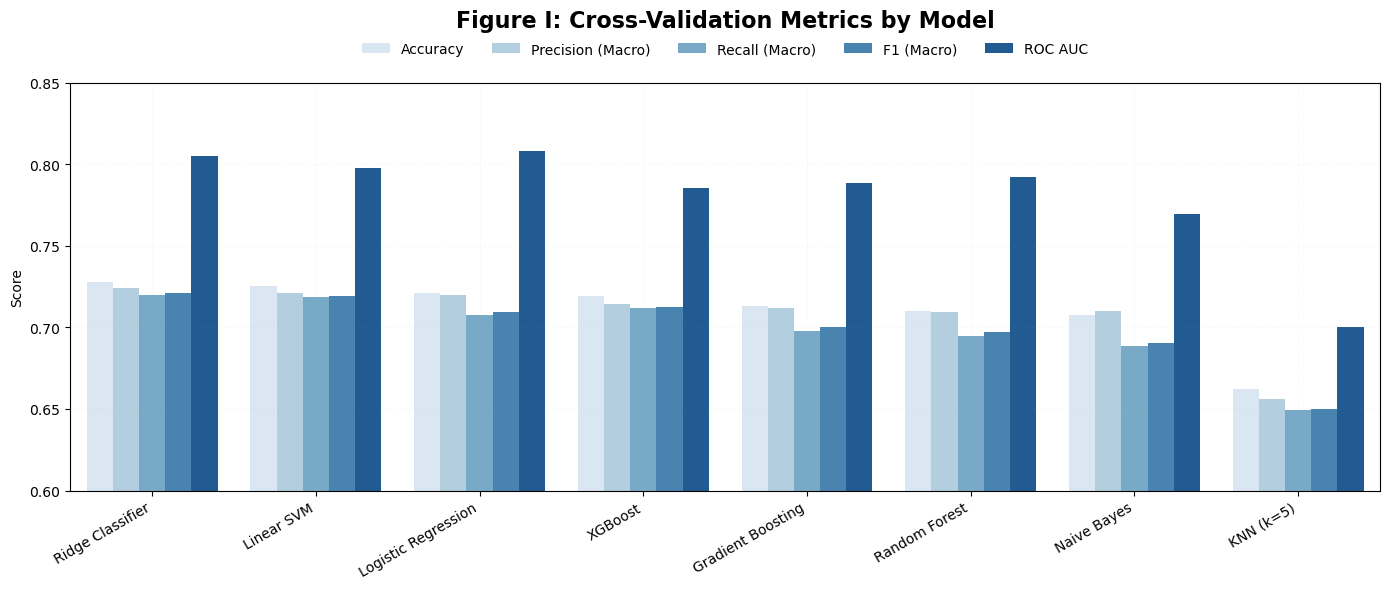

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to show
metrics_to_plot = ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 (Macro)", "ROC AUC"]

# Compute average score for sorting
model_metrics["Avg Score"] = model_metrics[metrics_to_plot].mean(axis=1)
sorted_models = model_metrics.sort_values("Avg Score", ascending=False).drop(columns=["Avg Score"])

# Melt DataFrame
melted = sorted_models.melt(id_vars="Model", value_vars=metrics_to_plot,
                            var_name="Metric", value_name="Score")

# Barplot
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=melted, x="Model", y="Score", hue="Metric", palette="Blues", ax=ax)

# Title
plt.title("Figure I: Cross-Validation Metrics by Model", fontsize=16, fontweight='bold', pad=40)

# Remove x-axis label
ax.set_xlabel("")

# Legend just under title
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.13),
    ncol=5,
    frameon=False
)

# Formatting
plt.ylabel("Score")
plt.ylim(0.6, 0.85)
plt.xticks(rotation=30, ha="right")
plt.grid(linestyle='--', alpha=0.05)

# Add space
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

A variety of models were evaluated using 5-fold cross-validation, including logistic regression, ridge classifier, support vector machine (SVM), random forest, gradient boosting, and XGBoost. As shown in Figure I, logistic regression performed competitively across all metrics, with a strong ROC AUC (0.81), F1 score, and balanced precision-recall tradeoffs. While tree-based models such as XGBoost also showed strong performance, the added complexity and lower interpretability made them less suitable for binary classification in this context. Logistic regression was chosen for its simplicity, strong generalisability, and highest ROC AUC. The model estimates the probability that a loan is high-need based on its TF-IDF features, following the form:
$$
\hat{y}_i = \frac{1}{1 + e^{-(\beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta})}}
$$
\begin{align*}
\text{where} \quad \hat{y}_i & = \text{predicted probability that observation } i \text{ is classified as high-need}, \\
\mathbf{x}_i & = \text{vector of features extracted from the loan description (TF-IDF scores)}, \\
\boldsymbol{\beta} & = \text{vector of feature weights learned by the model}, \\
\beta_0 & = \text{intercept term}.
\end{align*}


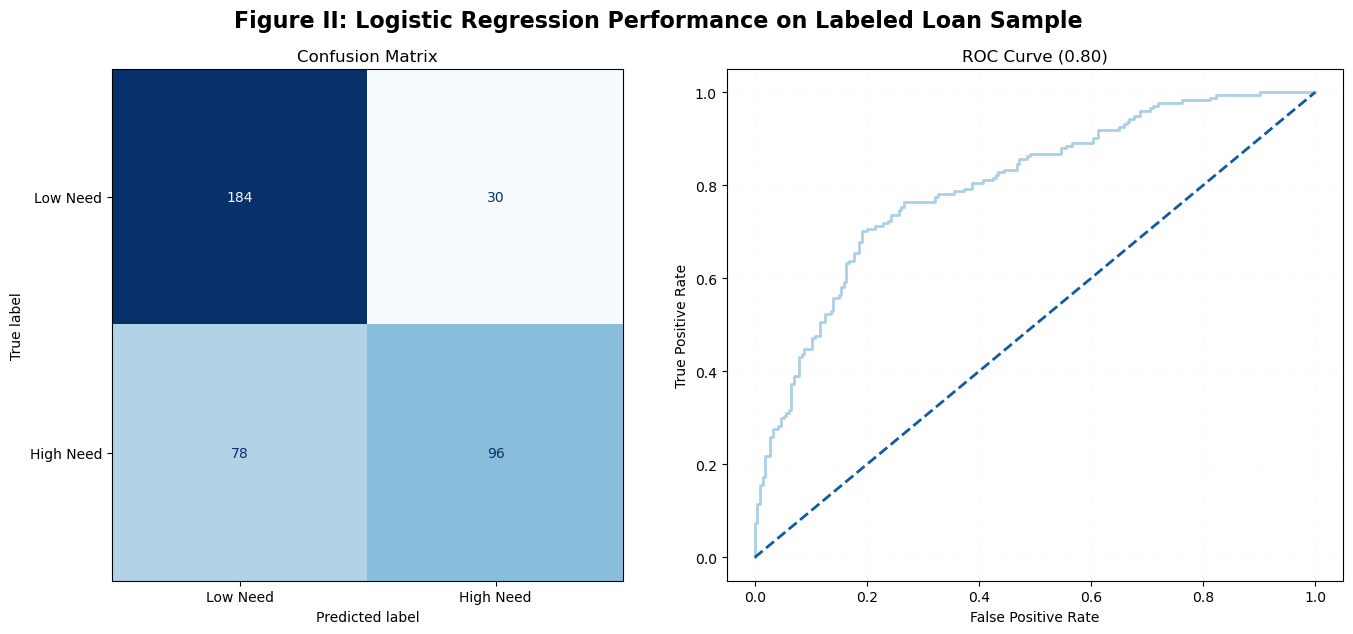

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

# Predict
y_pred = logit_model.predict(X_test)
y_probs = logit_model.predict_proba(X_test)[:, 1]

# ROC data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Custom labels
label_names = ["Low Need", "High Need"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Shared figure title
fig.suptitle("Figure II: Logistic Regression Performance on Labeled Loan Sample", fontsize=16, fontweight='bold', y=1.05)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title("Confusion Matrix")

# ROC Curve
axes[1].plot(fpr, tpr, color='#abd0e6', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='#105ba4', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (0.80)')
axes[1].grid(linestyle='--', alpha=0.05)

# Layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

As shown in Figure II, the logistic regression model, when applied to the labeled sample, demonstrates strong discriminative power, achieving an ROC AUC of 0.80. The confusion matrix further reveals reasonably balanced performance across both classes, correctly identifying 96 out of 174 high-need loans and 184 out of 214 low-need loans. While the model tends to be more precise in identifying low-need loans, it misclassifies a notable share of high-need observations as low-need. This asymmetry reflects a common challenge in text classification tasks, particularly when dealing with conceptually fuzzy categories like financial hardship.

The implication for the broader analysis is that while the model provides a strong signal of need, it is not perfect, some high-need borrowers may be underrepresented due to false negatives. This introduces a conservative bias into the subsequent regressions: any association between need and loan size is likely understated, not overstated. Despite this limitation, the model performs well on key evaluation metrics, including macro-averaged precision and recall, justifying its use for labeling the full dataset. The resulting binary variable serves as the primary proxy for borrower financial need in the analysis and enables a scalable, text-driven approach to measuring subjective hardship at the individual level.

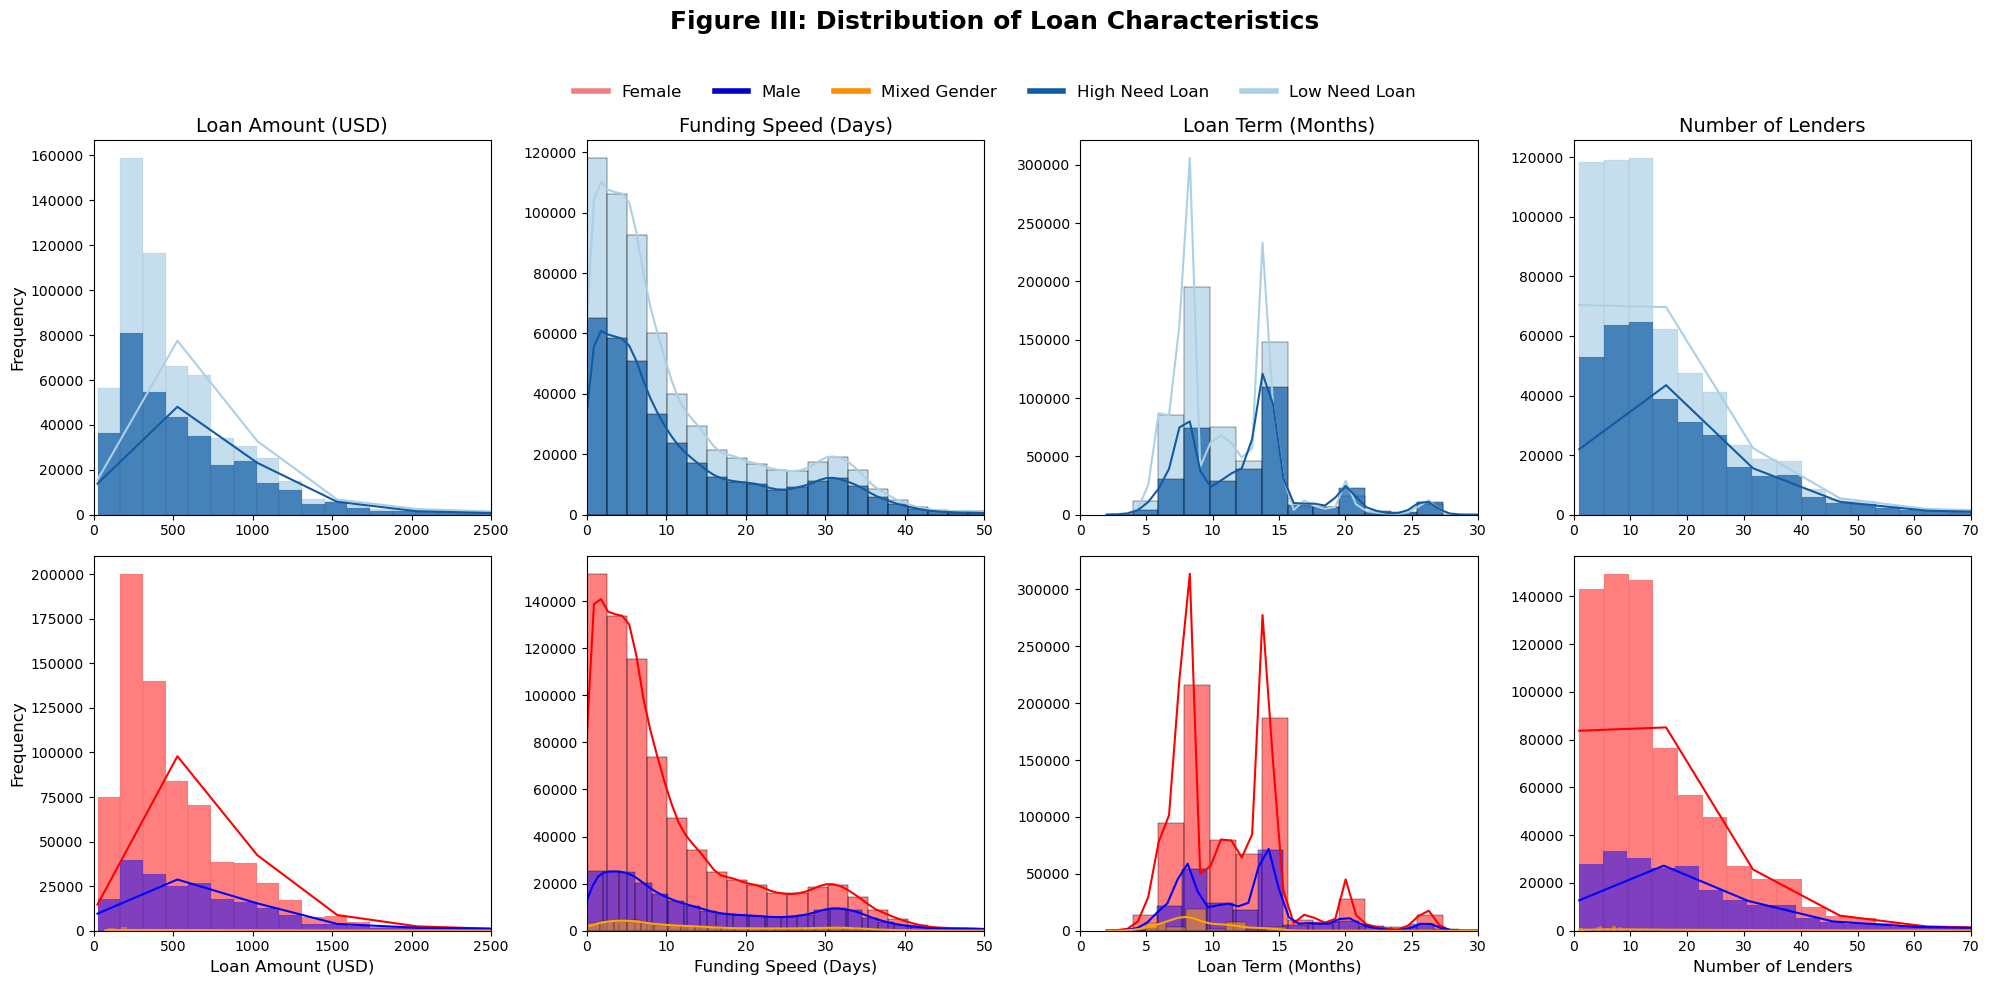

In [267]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  
fig.suptitle('Figure III: Distribution of Loan Characteristics', fontsize=18, fontweight='bold')

# Define variables for plotting
variables = [
    ('loan_amount', 'Loan Amount (USD)', (0, 2500), 700),
    ('funding_speed', 'Funding Speed (Days)', (0, 50), 70),
    ('lender_term', 'Loan Term (Months)', (0, 30), 80),
    ('num_lenders_total', 'Number of Lenders', (0, 70), 700)
]

# Define colours
need_colors = {0: '#abd0e6', 1: '#105ba4'}
gender_colors = {1: 'darkred', 0: 'mediumblue', "mixed": 'darkorange'}

# First row
for i, (ax, (var, xlabel, xlim, bins)) in enumerate(zip(axes[0], variables)):
    sns.histplot(data=df, x=var, hue="need_label", bins=bins, kde=True, 
                 palette=need_colors, hue_order=[1, 0], alpha=0.7, ax=ax, multiple='layer')

    if i == 0:  
        ax.set_ylabel('Frequency', fontsize=12)
    else:
        ax.set_ylabel('')  

    ax.set_title(xlabel, fontsize=14)  
    ax.set_xlabel('')  

    if xlim:
        ax.set_xlim(xlim)

    ax.grid(False)
    if ax.get_legend():
        ax.get_legend().remove()

# Second row
for i, (ax, (var, xlabel, xlim, bins)) in enumerate(zip(axes[1], variables)):
    sns.histplot(data=df[df["female"] == 1], x=var, bins=bins, kde=True, 
                 color='red', alpha=0.5, ax=ax, label="Female")
    
    sns.histplot(data=df[df["female"] == 0], x=var, bins=bins, kde=True, 
                 color='blue', alpha=0.5, ax=ax, label="Male")

    sns.histplot(data=df[df["mixed_gender"] == 1], x=var, bins=bins, kde=True, 
                 color='orange', alpha=0.5, ax=ax, label="Mixed Gender")

    if i == 0:  
        ax.set_ylabel('Frequency', fontsize=12)
    else:
        ax.set_ylabel('')  

    ax.set_xlabel(xlabel, fontsize=12)  
    ax.set_title('')  

    if xlim:
        ax.set_xlim(xlim)

    ax.grid(False)
    if ax.get_legend():
        ax.get_legend().remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.88])  
fig.subplots_adjust(top=0.85)  

# Define legend and move it
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='Female'),
    plt.Line2D([0], [0], color='mediumblue', lw=4, label='Male'),
    plt.Line2D([0], [0], color='darkorange', lw=4, label='Mixed Gender'),
    plt.Line2D([0], [0], color='#105ba4', lw=4, label='High Need Loan'),
    plt.Line2D([0], [0], color='#abd0e6', lw=4, label='Low Need Loan')
]

# Move the legend
fig.legend(handles=handles, loc='upper center', fontsize=12, ncol=5, frameon=False, bbox_to_anchor=(0.5, 0.92))

plt.show()

Figure III visualises the distribution of key loan attributes across borrower gender and need classifications. In the top row, high-need loans are shown to cluster around lower amounts, shorter terms, and fewer lenders, suggesting these borrowers may face more limited support or are requesting less due to financial constraints. Interestingly, these loans also take slightly longer to fund, reinforcing the earlier observation that slower funding times may signal higher perceived risk (Huang et al., 2019).

The lower row reveals notable gender-based differences: male borrowers tend to receive larger loans, longer terms, and are funded less quickly than female borrowers. Female borrowers dominate the distribution of smaller, shorter term loans, while mixed-gender groups appear relatively rare across all dimensions. These visual disparities show patterns later confirmed by the regression analysis, particularly the persistent gap in loan conditions by gender and financial need.

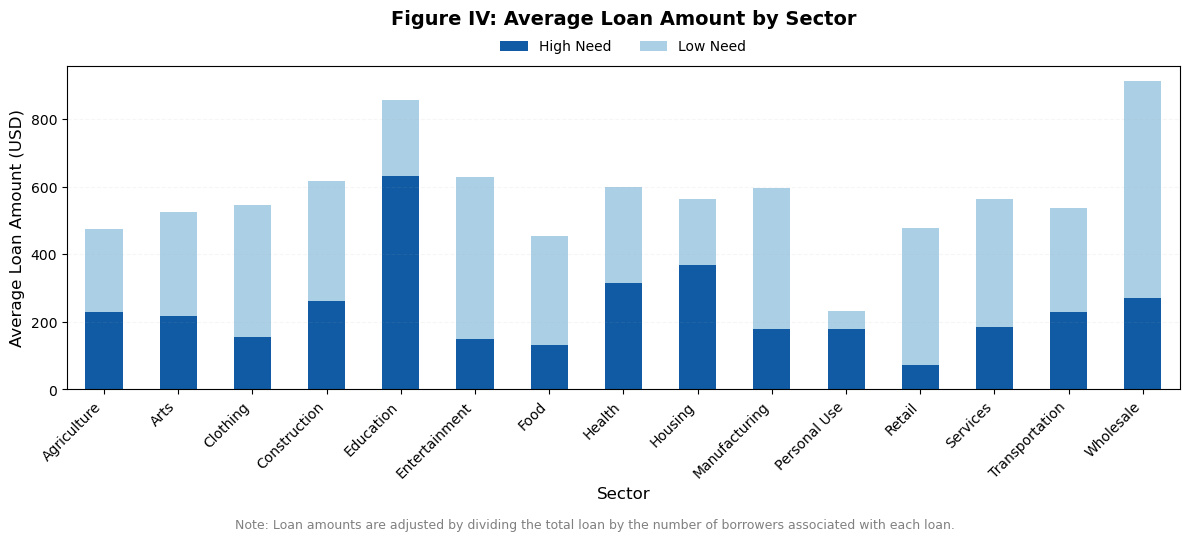

In [431]:
import matplotlib.pyplot as plt

# Map need_label to readable categories
df["Need Category"] = df["need_label"].map({0: "Low Need", 1: "High Need"})

# Compute total adjusted loan amount per sector
sector_avg_loan_adj = df.groupby("sector_name")["loan_amount_adj"].mean()

# Compute loan frequency per need label within each sector (normalized to 1)
sector_need_dist = df.groupby(["sector_name", "Need Category"])["loan_id"].count().unstack()
sector_need_dist = sector_need_dist.div(sector_need_dist.sum(axis=1), axis=0)  # Normalize

# Multiply by sector-level average adjusted loan amount to retain correct bar height
sector_stacked = sector_need_dist.mul(sector_avg_loan_adj, axis=0)

# Define custom colors
custom_colors = {
    "High Need": "#105ba4",
    "Low Need": "#abd0e6"
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stacked bar chart
sector_stacked.plot(kind="bar", stacked=True, ax=ax, 
                    color=[custom_colors[col] for col in sector_stacked.columns])

# Formatting
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Average Loan Amount (USD)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.1)

# Title
plt.title("Figure IV: Average Loan Amount by Sector", fontsize=14, fontweight="bold", pad=30)

# Legend under the title
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.75)

# Footnote
fig.text(
    0.5, -0.02,
    "Note: Loan amounts are adjusted by dividing the total loan by the number of borrowers associated with each loan.",
    ha="center", fontsize=9, color="gray"
)

plt.show()

Figure IV visualises average loan amounts across sectors, with bars disaggregated by need category to show the proportion of high and low need loans within each sector. The figure highlights how much of each sector’s total lending volume is allocated to high versus low need borrowers.

Notably, sectors such as education, housing, and manufacturing not only receive higher average loan amounts overall, but also show a sizable portion of these funds going to high-need borrowers. In contrast, sectors like retail, personal use, and entertainment allocate a much larger share of their loan volume to low-need borrowers, despite often serving high-need populations. This suggests that while high-need loans are present across all sectors, the largest loans within each sector may still be directed toward lower-need cases, raising questions about the extent to which financial vulnerability drives loan allocation decisions.

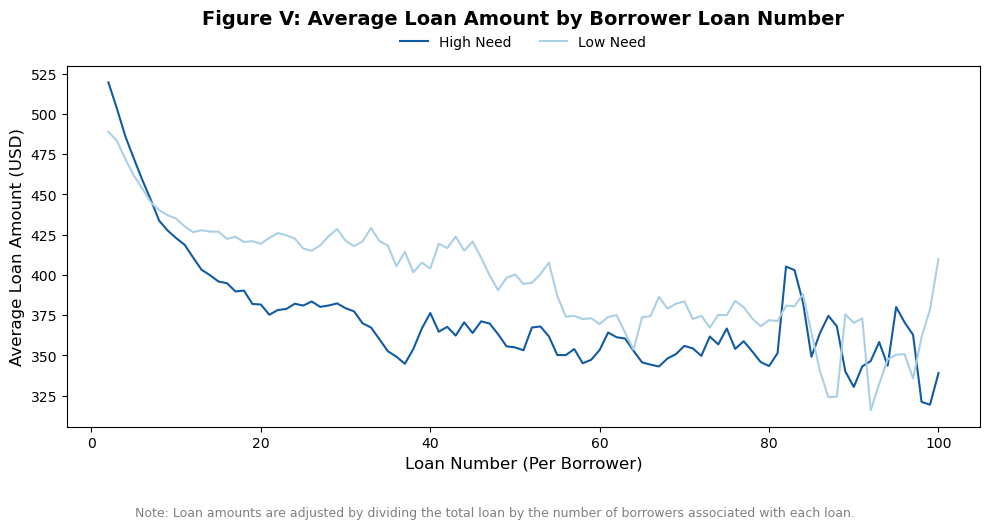

In [439]:
import matplotlib.pyplot as plt
import pandas as pd

cutoff = 100

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Smoothed line
for label, name, color in zip([1, 0], ["High Need", "Low Need"], ["#105ba4", "#abd0e6"]):
    avg = df[df["need_label"] == label].groupby("loan_sequence")["loan_amount_adj"].mean()
    smoothed = avg.rolling(window=3, center=True).mean()
    smoothed = smoothed[smoothed.index <= cutoff]
    ax.plot(smoothed.index, smoothed.values, label=name, color=color)

# Title and labels
ax.set_title("Figure V: Average Loan Amount by Borrower Loan Number", fontsize=14, fontweight='bold', pad=30)
ax.set_xlabel("Loan Number (Per Borrower)", fontsize=12)
ax.set_ylabel("Average Loan Amount (USD)", fontsize=12)

# Legend below title
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False
)

# Footnote
fig.text(
    0.5, -0.05,
    "Note: Loan amounts are adjusted by dividing the total loan by the number of borrowers associated with each loan.",
    ha="center", fontsize=9, color="gray"
)

# Grid and layout
ax.grid(False)
plt.tight_layout()
plt.subplots_adjust(top=0.7)  
plt.show()

Figure V visualises the evolution of average loan amounts by borrower loan number, broken down by high and low need classifications. A clear downward trend is visible in the early stages: for both groups, loan amounts tend to decrease steadily as borrowers take out more loans, particularly during the first 30 loans. This pattern may reflect either declining marginal institutional support, perhaps due to lender caution or a preference for distributing limited resources broadly, or a form of borrower dependency, where repeat users rely on small recurring disbursements rather than progressing toward financial independence.

However, beyond the 80th loan, the data becomes distinctly erratic, with visible fluctuations that do not reflect consistent patterns. This volatility can be explained by the sharp drop in sample size at high loan counts: only around 4,000 loans in the dataset correspond to borrowers taking their 80th loan or more. At this level, estimates are based on a small subset of outlier borrowers, making them sensitive to noise and less statistically reliable. As a result, everything at the right tail of the distribution should be interpreted with caution.

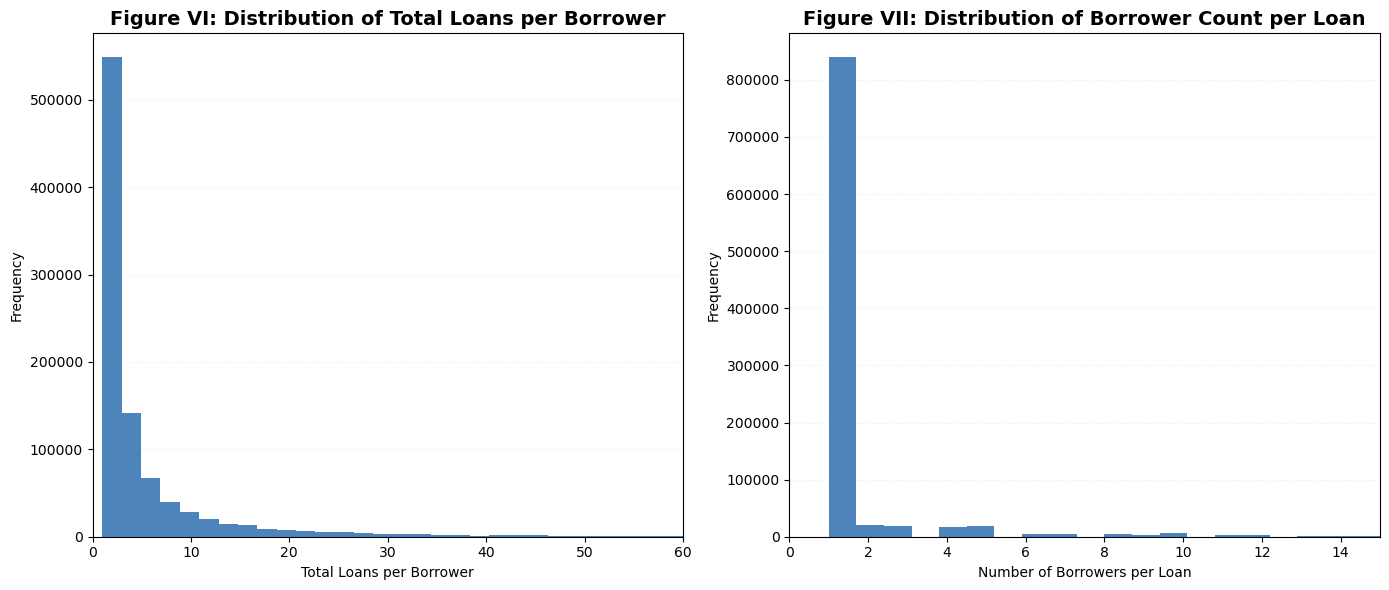

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(14, 6))

# Histogram 1
plt.subplot(1, 2, 1)
sns.histplot(
    df[df['total_loans_borrower'] <= 60]['total_loans_borrower'],
    bins=30, kde=False, color='#105ba4', edgecolor=None
)
plt.title("Figure VI: Distribution of Total Loans per Borrower", fontsize=14, fontweight='bold')
plt.xlabel("Total Loans per Borrower")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.xlim(0, 60)

# Histogram 2
plt.subplot(1, 2, 2)
sns.histplot(
    df[df['borrower_count'] <= 15]['borrower_count'],
    bins=20, kde=False, color='#105ba4', edgecolor=None
)
plt.title("Figure VII: Distribution of Borrower Count per Loan", fontsize=14, fontweight='bold')
plt.xlabel("Number of Borrowers per Loan")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.xlim(0, 15)
plt.tight_layout()
plt.show()

Figures VI and VII illustrate key dimensions of loan and borrower characteristics in the dataset. Figure VI shows the distribution of total loans per borrower, revealing that most borrowers take out only a few loans, with the majority clustered around a single borrowing instance. However, a long tail is visible, with some individuals taking out dozens of loans, indicating a relatively small group of highly frequent borrowers. 

Figure VII displays the distribution of borrower count per loan, showing that the overwhelming majority of loans are issued to single individuals. This aligns with prior summary statistics indicating an average of 1.6 borrowers per loan, but the chart confirms that loans with multiple borrowers are relatively rare. These insights support the analytical decision to focus on individual borrowing trajectories, while also validating the inclusion of group loan controls in later regression analysis.

# Project 2

## 2.1 The Message

**Despite targeting underserved communities, microfinance institutions do not consistently scale loan sizes with borrower need over time, suggesting that repeated lending may entrench dependency rather than foster financial progress.**

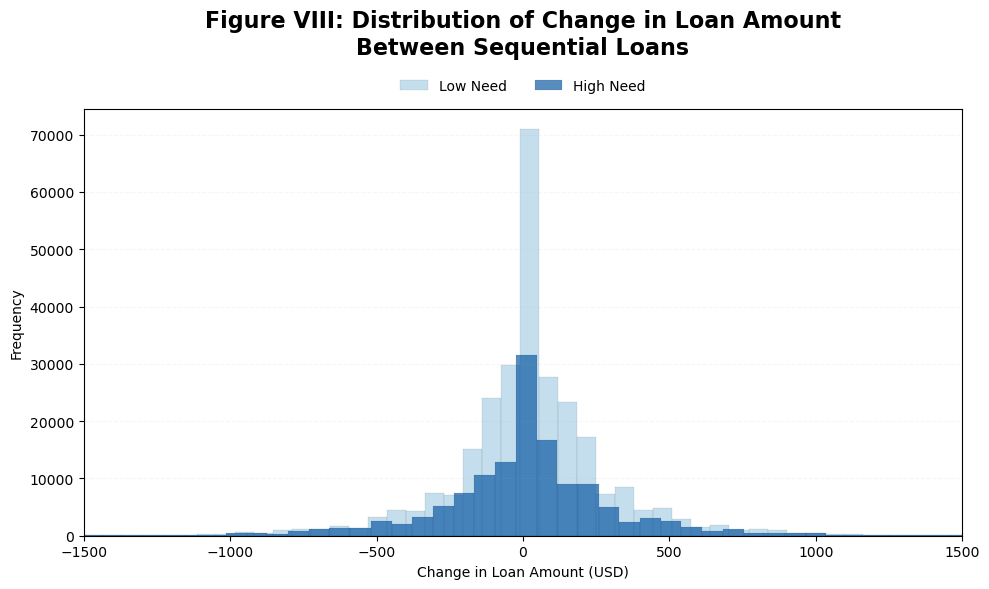

In [491]:
plt.figure(figsize=(10, 6))

# Plot Low Need
sns.histplot(
    data=df_filtered[df_filtered["need_label"] == 0],
    x="loan_change", bins=1000, color="#abd0e6", label="Low Need",
    stat="count", alpha=0.7
)

# Plot High Need
sns.histplot(
    data=df_filtered[df_filtered["need_label"] == 1],
    x="loan_change", bins=1000, color="#105ba4", label="High Need",
    stat="count", alpha=0.7
)

# Title and labels
plt.title("Figure VIII: Distribution of Change in Loan Amount\nBetween Sequential Loans",
          fontsize=16, fontweight="bold", pad=40)
plt.xlabel("Change in Loan Amount (USD)")
plt.ylabel("Frequency")
plt.xlim(-1500, 1500)
plt.grid(axis='y', linestyle='--', alpha=0.1)

# Legend below title
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


Figure VIII displays the distribution of changes in loan amounts between sequential loans of the same borrowers, separated by high and low need classifications. While the distributions for both groups are centered around zero and seem to follow a normal distribution, indicating that most borrowers receive similar loan amounts over time, high-need borrowers exhibit a slightly wider spread. This suggests greater variability in loan growth for financially vulnerable clients, but the overall similarity in shapes implies that loan progression is not heavily influenced by borrower need classification.

## 2.2 Maps and Interpretations

In [311]:
import geopandas as gpd
from shapely.geometry import Point

# Convert loan data to GeoDataFrame
df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
loans_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  

phl_gdf = gpd.read_file("/Users/jakubriha/Desktop/ECO225/phl_adm_psa_namria_20231106_shp/phl_admbnda_adm1_psa_namria_20231106.shp")
phl_gdf = phl_gdf.to_crs("EPSG:4326")  

ken_gdf = gpd.read_file("/Users/jakubriha/Desktop/ECO225/ken_adm_iebc_20191031_shp/ken_admbnda_adm1_iebc_20191031.shp")
ken_gdf = ken_gdf.to_crs("EPSG:4326")   

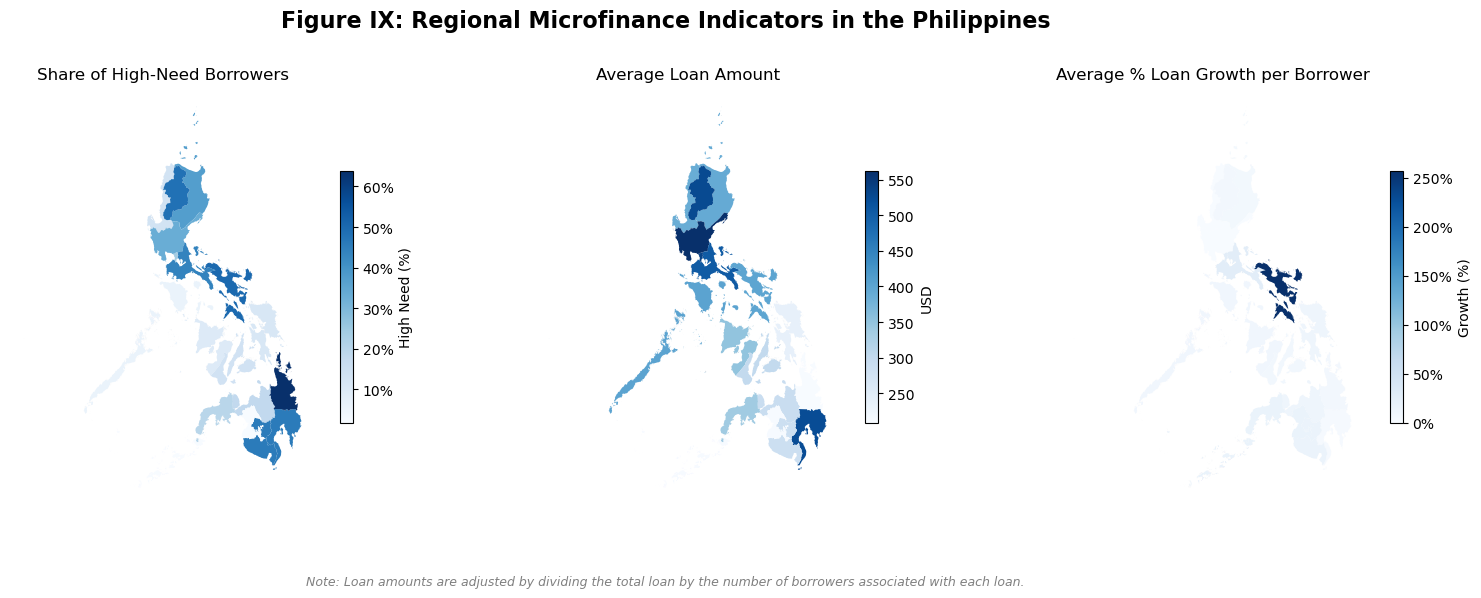

In [341]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Spatial join
loans_with_regions = gpd.sjoin(loans_gdf, phl_gdf, how="left", predicate="within")

# Share of High-Need Borrowers
agg1 = loans_with_regions.groupby("ADM1_EN")["need_label"].mean().reset_index(name="pct_high_need")

# Average Adjusted Loan Amount
agg2 = loans_with_regions.groupby("ADM1_EN")["loan_amount_adj"].mean().reset_index(name="avg_loan_amt_adj")

# Percentage Change in Adjusted Loan Amount per Borrower
borrower_deltas = loans_with_regions.sort_values(['borrower_id', 'loan_sequence']) \
    .groupby('borrower_id') \
    .agg(first_loan=('loan_amount_adj', 'first'),
         last_loan=('loan_amount_adj', 'last'),
         region=('ADM1_EN', 'first'))

borrower_deltas['loan_growth_pct'] = (borrower_deltas['last_loan'] - borrower_deltas['first_loan']) / borrower_deltas['first_loan']
agg3 = borrower_deltas.groupby("region")["loan_growth_pct"].mean().reset_index(name="avg_loan_growth_pct")

# Merge with shapefile
merged1 = phl_gdf.merge(agg1, on="ADM1_EN", how="left")
merged2 = phl_gdf.merge(agg2, on="ADM1_EN", how="left")
merged3 = phl_gdf.merge(agg3, left_on="ADM1_EN", right_on="region", how="left")

# Plott
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.05, top=0.85, bottom=0.15)

# Share of High-Need Borrowers 
cax1 = merged1.plot(
    column="pct_high_need", cmap="Blues", ax=axes[0], legend=True,
    legend_kwds={"shrink": 0.6, "label": "High Need (%)"}
)
axes[0].set_title("Share of High-Need Borrowers", fontsize=12)
axes[0].axis("off")
cax1.get_figure().axes[-1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# 2. Loan Amount
cax2 = merged2.plot(
    column="avg_loan_amt_adj", cmap="Blues", ax=axes[1], legend=True,
    legend_kwds={"shrink": 0.6, "label": "USD"}
)
axes[1].set_title("Average Loan Amount", fontsize=12)
axes[1].axis("off")

# 3. % Loan Growth per Borrower
cax3 = merged3.plot(
    column="avg_loan_growth_pct", cmap="Blues", ax=axes[2], legend=True,
    legend_kwds={"shrink": 0.6, "label": "Growth (%)"}
)
axes[2].set_title("Average % Loan Growth per Borrower", fontsize=12)
axes[2].axis("off")
cax3.get_figure().axes[-1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Suptitle
fig.suptitle("Figure IX: Regional Microfinance Indicators in the Philippines", fontsize=16, fontweight="bold")

# footnote
fig.text(
    0.5, 0.02,
    "Note: Loan amounts are adjusted by dividing the total loan by the number of borrowers associated with each loan.",
    ha='center', fontsize=9, color='gray', style='italic'
)

plt.show()

Figure IX illustrates microfinance patterns across Philippine regions, the country with the highest number of loans in the dataset (267,887). The leftmost panel shows that the share of high-need borrowers is highest in Mindanao and parts of the Visayas, suggesting elevated financial vulnerability in these areas. However, the center panel reveals that regions with the highest average loan amounts are concentrated in northern Luzon, particularly around Metro Manila, implying a possible mismatch between regional need and financial support. Interestingly, average loan growth per borrower (rightmost panel) is also concentrated in the north, indicating that more affluent regions not only receive larger initial loans but also experience greater growth across borrowing cycles. the Bangko Sentral ng Pilipinas (BSP) 2021 Financial Inclusion Survey indicates that microfinance non-governmental organizations (NGOs) are the primary formal credit sources in Luzon and Visayas, while cooperatives play a more significant role in Mindanao. This suggests regional variations in financial service accessibility, potentially contributing to the observed mismatches between borrower need and financial support across different areas.

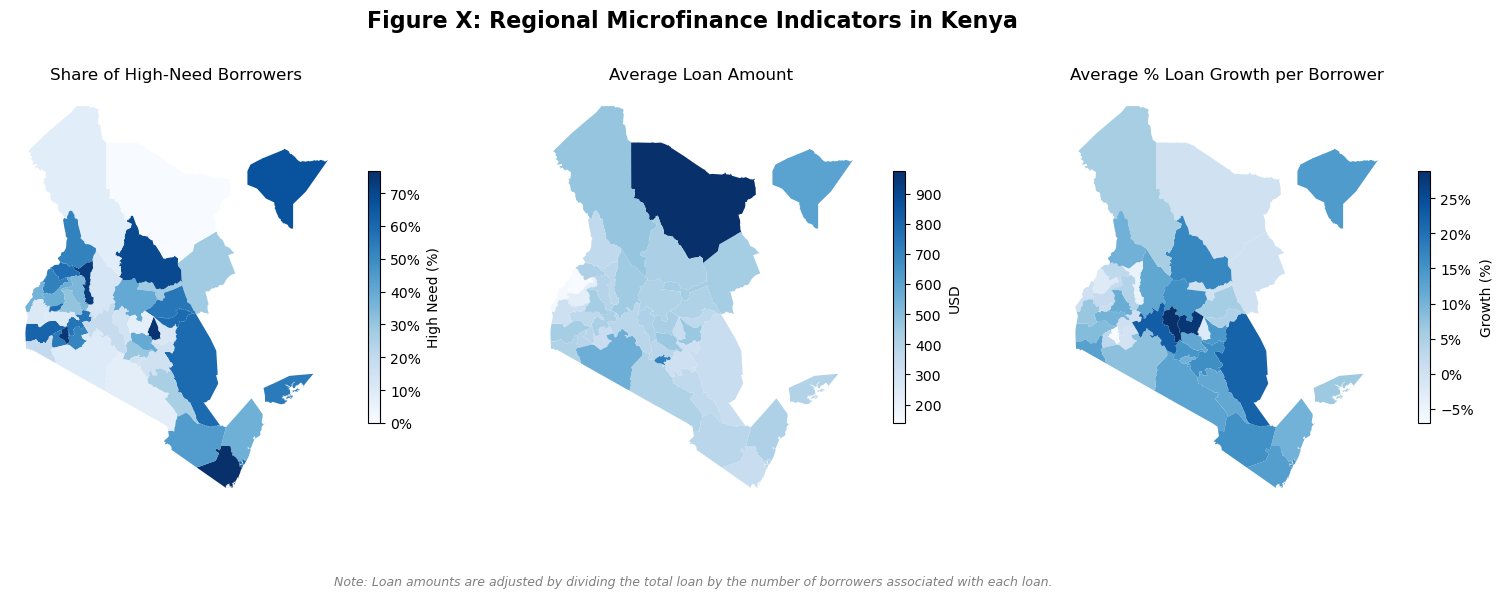

In [343]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

# Spatial join
loans_with_regions_kenya = gpd.sjoin(loans_gdf, ken_gdf, how="left", predicate="within")

# Share of High-Need Borrowers
agg1_kenya = loans_with_regions_kenya.groupby("ADM1_EN")["need_label"].mean().reset_index(name="pct_high_need")

# Average Adjusted Loan Amount
agg2_kenya = loans_with_regions_kenya.groupby("ADM1_EN")["loan_amount_adj"].mean().reset_index(name="avg_loan_amt")

# Percentage Loan Growth per Borrower
borrower_deltas_kenya = loans_with_regions_kenya.sort_values(['borrower_id', 'loan_sequence']) \
    .groupby('borrower_id') \
    .agg(first_loan=('loan_amount_adj', 'first'),
         last_loan=('loan_amount_adj', 'last'),
         region=('ADM1_EN', 'first'))

borrower_deltas_kenya['loan_growth_pct'] = (
    (borrower_deltas_kenya['last_loan'] - borrower_deltas_kenya['first_loan']) / borrower_deltas_kenya['first_loan']
)
agg3_kenya = borrower_deltas_kenya.groupby("region")["loan_growth_pct"].mean().reset_index(name="avg_loan_growth_pct")

# Merge
merged1_kenya = ken_gdf.merge(agg1_kenya, on="ADM1_EN", how="left")
merged2_kenya = ken_gdf.merge(agg2_kenya, on="ADM1_EN", how="left")
merged3_kenya = ken_gdf.merge(agg3_kenya, left_on="ADM1_EN", right_on="region", how="left")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.05, top=0.85, bottom=0.15)

# Share of High-Need Borrowers
cax1 = merged1_kenya.plot(
    column="pct_high_need", cmap="Blues", ax=axes[0], legend=True,
    legend_kwds={"shrink": 0.6, "label": "High Need (%)"}
)
axes[0].set_title("Share of High-Need Borrowers", fontsize=12)
axes[0].axis("off")
cax1.get_figure().axes[-1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Average Loan Amount (USD)
cax2 = merged2_kenya.plot(
    column="avg_loan_amt", cmap="Blues", ax=axes[1], legend=True,
    legend_kwds={"shrink": 0.6, "label": "USD"}
)
axes[1].set_title("Average Loan Amount", fontsize=12)
axes[1].axis("off")

# Loan Growth per Borrower
cax3 = merged3_kenya.plot(
    column="avg_loan_growth_pct", cmap="Blues", ax=axes[2], legend=True,
    legend_kwds={"shrink": 0.6, "label": "Growth (%)"}
)
axes[2].set_title("Average % Loan Growth per Borrower", fontsize=12)
axes[2].axis("off")
cax3.get_figure().axes[-1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Title
fig.suptitle("Figure X: Regional Microfinance Indicators in Kenya", fontsize=16, fontweight="bold")

# Footnote
fig.text(
    0.5, 0.02,
    "Note: Loan amounts are adjusted by dividing the total loan by the number of borrowers associated with each loan.",
    ha='center', fontsize=9, color='gray', style='italic'
)
plt.show()

Kenya, with the second-largest loan volume in the dataset (112,192 loans), displays a similarly uneven distribution of microfinance indicators. As shown in the left panel, high-need borrowers are concentrated in western and northern regions. Yet, the central and northern counties, especially those surrounding Nairobi, receive higher average loan amounts (middle panel), suggesting that lending favours economically vibrant or urban areas. Research by Muthoni and Lewa (2017) highlights that regions such as Nairobi and Rift Valley have the highest outstanding loan amounts, despite high concentrations of high need borrowers in western and northern regions. This pattern confirms that microfinance lending may favour more economically vibrant or urban areas, potentially overlooking regions with greater financial vulnerability. Notably, the rightmost panel shows that loan growth is more evenly distributed, with some rural counties exhibiting substantial increases across borrowing cycles. This pattern may reflect the success of localised lending programmes, or the gradual trust building process between rural borrowers and lenders.

## 2.3 Regressions

To examine how loan allocation is associated with borrower characteristics, loan traits, and regional indicators of need, this section begins by modelling the determinants of loan size using a series of Ordinary Least Squares (OLS) regressions. The dependent variable is the natural logarithm of the loan amount, and the main explanatory variable of interest is the binary indicator for whether the borrower is classified as "high need." The analysis incrementally adds borrower demographics, loan level features, and fixed effects for sector, year, and country. This allows for a progressively more robust comparison of loan sizes across different borrower profiles while controlling for potential sources of omitted variable bias. The baseline model is specified as:

$$
\log(\text{LoanAmount}_i) = \beta_0 + \beta_1 \cdot \text{HighNeed}_i + \mathbf{X}_i \boldsymbol{\gamma} + \alpha_s + \delta_t + \lambda_c + \epsilon_i
$$

Where:
- $\text{HighNeed}_i$ is a dummy equal to 1 if the loan is classified as high-need.
- $\mathbf{X}_i$ is a vector of borrower and loan level control variables (gender, group loan, loan term).
- $\alpha_s$, $\delta_t$, and $\lambda_c$ represent sector, year, and country fixed effects, respectively.
- $\epsilon_i$ is the error term.

In [347]:
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf
from IPython.display import display, HTML
import numpy as np

# Log-transform loan amount
df['log_loan_amount'] = np.log1p(df['loan_amount'])

# Regression formulas
formulas = {
    "Baseline Model": "log_loan_amount ~ need_label",
    "Add Basic Controls": "log_loan_amount ~ need_label + mpi_standardised + female + mixed_gender + borrower_count",
    "Need × MPI Interaction": "log_loan_amount ~ need_label + mpi_standardised + need_label * mpi_standardised + female + mixed_gender + borrower_count",
    "Need × Gender Interaction": "log_loan_amount ~ need_label + mpi_standardised + female + mixed_gender + need_label * female + borrower_count",
    "Both Interactions": "log_loan_amount ~ need_label + mpi_standardised + need_label * mpi_standardised + female + mixed_gender + need_label * female + borrower_count",
    "Full Controls": "log_loan_amount ~ need_label + mpi_standardised + female + mixed_gender + borrower_count + borrower_pictured + is_group_loan + repeat_borrower + funding_speed + lender_term + num_lenders_total + C(sector_name) + C(year) + C(country_name)",
    "Full + Need × MPI": "log_loan_amount ~ need_label + mpi_standardised + need_label * mpi_standardised + female + mixed_gender + borrower_count + borrower_pictured + is_group_loan + repeat_borrower + funding_speed + lender_term + num_lenders_total + C(sector_name) + C(year) + C(country_name)",
    "Full + Need × Gender": "log_loan_amount ~ need_label + mpi_standardised + female + mixed_gender + need_label * female + borrower_count + borrower_pictured + is_group_loan + repeat_borrower + funding_speed + lender_term + num_lenders_total + C(sector_name) + C(year) + C(country_name)",
    "Full + Both Interactions": "log_loan_amount ~ need_label + mpi_standardised + need_label * mpi_standardised + female + mixed_gender + need_label * female + borrower_count + borrower_pictured + is_group_loan + repeat_borrower + funding_speed + lender_term + num_lenders_total + C(sector_name) + C(year) + C(country_name)"
}

# Run the regressions
results = {name: smf.ols(formula, data=df).fit() for name, formula in formulas.items()}

# Stargazer
stargazer = Stargazer(list(results.values()))
stargazer.title("Regression I: Determinants of Log Loan Amount")
stargazer.dependent_variable_name("Log(Loan Amount)")
stargazer.custom_columns(list(formulas.keys()), [1] * len(formulas))

# Define covariate order
stargazer.covariate_order([
    "need_label", 
    "mpi_standardised", 
    "female", 
    "mixed_gender",
    "borrower_count",
    "need_label:mpi_standardised", 
    "need_label:female",
    "borrower_pictured", 
    "is_group_loan", 
    "repeat_borrower",  
    "funding_speed", 
    "lender_term", 
    "num_lenders_total"
])

# Rename covariates
stargazer.rename_covariates({
    "need_label": "High Need Loan Dummy",
    "mpi_standardised": "MPI Value (Standardised)",
    "female": "Female Borrower Dummy",
    "mixed_gender": "Mixed-Gender Loan Dummy",
    "borrower_count": "Number of Borrowers",
    "need_label:mpi_standardised": "High Need × MPI",
    "need_label:female": "High Need × Female",
    "borrower_pictured": "Borrower Pictured in Loan Ad",
    "is_group_loan": "Group Loan Dummy",
    "repeat_borrower": "Repeat Borrower Dummy",
    "funding_speed": "Funding Speed (Days)",
    "lender_term": "Loan Term (Months)",
    "num_lenders_total": "Number of Lenders"
})

# Add FEs
stargazer.add_line("Sector Fixed Effects", [""] * 5 + ["✔"] * 4)
stargazer.add_line("Year Fixed Effects", [""] * 5 + ["✔"] * 4)
stargazer.add_line("Country Fixed Effects", [""] * 5 + ["✔"] * 4)

display(HTML(stargazer.render_html()))

Regression I explores how need level relates to loan amounts using OLS models with progressively more controls and interactions. A consistent finding is that mixed-gender borrowing groups receive significantly smaller loans—13.4 percentage points less than female-only groups—even after adjusting for sector, year, and country, suggesting either institutional bias or lower demand from such groups. Another robust result is the negative relationship between MPI and loan size: a one standard deviation increase in MPI corresponds to a 3–7% reduction in loan amount, likely due to lower purchasing power in poorer regions.

The high-need dummy initially shows a positive effect but becomes significantly negative (–8.7%) in the fully controlled model, implying that loans perceived as high-need are penalized once borrower and contextual factors are considered. Interestingly, its interaction with MPI becomes positive in the final model, suggesting this penalty weakens in poorer regions.

Gender interactions further reveal that while female borrowers receive smaller loans on average (–5%), those expressing high need get relatively larger loans than low-need women, partially offsetting the gender gap. Repeat borrowers receive 8.2% larger loans, consistent with relationship lending. Other controls behave as expected: longer loan terms, faster funding speeds, and more lenders are associated with larger disbursements.

Regression II shifts focus to loan evolution over time, analyzing how loan size changes across borrowing sequences. By introducing loan sequence and borrower-level fixed effects, the model tracks whether institutions increase, maintain, or reduce support over time. This approach effectively transforms the data into a borrower-level panel, allowing closer study of lending dynamics.

$$
\log(\text{LoanAmount}_{it}) = \alpha + \beta_1 \text{LoanSeq}_{it} + \mathbf{X}_{it}'\boldsymbol{\gamma} + \mathbf{Z}_{it}'\boldsymbol{\delta} + \boldsymbol{\lambda}_{\text{sector}} + \boldsymbol{\theta}_{\text{country}} + \varepsilon_{it}
$$


Where:

- $\text{LoanSeq}_{it}$ is the loan sequence number (whether it's a borrower’s first, second, or third loan),

- $\mathbf{X}_{it}$ represents time-varying borrower characteristics (gender, perceived financial need),

- $\mathbf{Z}_{it}$ includes loan-level characteristics (loan term, funding speed, number of lenders),

- $\boldsymbol{\lambda}{\text{sector}}$ and $\boldsymbol{\theta}{\text{country}}$ are fixed effects for sector and country,

- $\varepsilon_{it}$ is the error term.

This setup allows us to estimate how loan size evolves across borrowing rounds, while controlling for observed heterogeneity.

In [385]:
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from IPython.display import display, HTML

# Define regression formulas
formulas = {
    "Baseline Sequence Trend": "log_loan_amount_adj ~ loan_sequence",
    "Interaction w/ Gender": "log_loan_amount_adj ~ loan_sequence + female + mixed_gender + loan_sequence*female",
    "Interaction w/ Need": "log_loan_amount_adj ~ loan_sequence + need_label + loan_sequence*need_label",
    "Interaction w/ Gender & Need": "log_loan_amount_adj ~ loan_sequence + female + mixed_gender + need_label + loan_sequence*female + loan_sequence*need_label",
    "Full Model w/ Controls": "log_loan_amount_adj ~ loan_sequence + female + mixed_gender + need_label + loan_sequence*female + loan_sequence*need_label + borrower_pictured + lender_term + funding_speed + num_lenders_total + repeat_borrower + C(sector_name) + C(country_name)"
}

# Run regressions
results = {name: smf.ols(formula, data=df).fit() for name, formula in formulas.items()}

# Stargazer
stargazer = Stargazer(list(results.values()))
stargazer.title("Regression II: Loan Progression Across Sequential Borrowings")
stargazer.dependent_variable_name("Log Loan Amount (Adjusted)")
stargazer.custom_columns(list(formulas.keys()), [1] * len(formulas))

# Covariate renaming
stargazer.rename_covariates({
    "loan_sequence": "Loan Number (Sequence)",
    "female": "Female Borrower Dummy",
    "mixed_gender": "Mixed-Gender Borrower Dummy",
    "need_label": "High Need Loan Dummy",
    "loan_sequence:female": "Loan Sequence × Female",
    "loan_sequence:need_label": "Loan Sequence × High Need",
    "lender_term": "Loan Term (Months)",
    "funding_speed": "Funding Speed (Days)",
    "num_lenders_total": "Number of Lenders",
    "repeat_borrower": "Repeat Borrower Dummy",
    "borrower_pictured": "Borrower Pictured in Loan Ad"
})

# Covariate order
stargazer.covariate_order([
    "loan_sequence", "female", "mixed_gender", "need_label",
    "loan_sequence:female", "loan_sequence:need_label",
    "borrower_pictured", "lender_term",
    "funding_speed", "num_lenders_total", "repeat_borrower"
])

# FE indicators
stargazer.add_line("Sector Fixed Effects", [""] * 4 + ["✔"])
stargazer.add_line("Country Fixed Effects", [""] * 4 + ["✔"])

display(HTML(stargazer.render_html()))

Regression II explores the relationship between loan size and sequential borrowing behaviour across all borrowers in the dataset. Model (1) shows that loan amounts slightly decrease with each subsequent borrowing: the coefficient of -0.004 suggests a 0.4% reduction in loan size with each additional loan on average, across all borrowers. However, this pooled result might conflate two effects: individual borrower trajectories and differences between borrowers at different borrowing stages.

Model (2) adds gender controls and interactions. The positive interaction between loan sequence and female (0.007) suggests that, over time, female borrowers see a modest increase in loan size relative to male borrowers, though the baseline trend remains negative.

The full model (Model 5), which includes sector and country fixed effects and controls for loan characteristics, confirms these findings. The loan sequence coefficient remains negative, albeit small (−0.004), and the high-need dummy remains strongly negative (−0.056), even after accounting for other factors. This again suggests that institutions are not rewarding perceived financial need with larger loans, and may in fact be doing the opposite.

However, because this model does not control for unobserved borrower level heterogeneity, it's possible that observed patterns are driven by differences between borrowers rather than changes within them. For example, borrowers who take out many loans may be systematically different (more financially constrained or less creditworthy) than those who take out fewer, and those differences may drive the observed decline in loan size over time.

To more accurately isolate how loan sizes evolve within individual borrowers, Regression III applies borrower fixed effects. By controlling for borrower specific, time invariant characteristics, the fixed effects model removes this confounding and captures true within borrower dynamics. However, including fixed effects for nearly a million borrowers is computationally infeasible using dummy variables. Instead, the model employs a within transformation, where both the dependent and independent variables are mean-centered at the borrower level.
Mathematically, each variable $X_{it}$ is transformed as:

$$
\tilde{X}_{it} = X_{it} - \bar{X}_i
$$

where $\bar{X}_i$ is the average of variable $X$ across all loans for borrower $i$. The regression is then run on these transformed variables:

$$
\tilde{Y}_{it} = \beta \tilde{X}_{it} + \epsilon_{it}
$$

This is algebraically equivalent to including individual dummy variables for each borrower, like in a fixed effects model, but is far more efficient computationally. It also means that only time varying variables (like loan sequence or need) can be interpreted, while any time invariant characteristics (gender, initial risk profile) are absorbed by the fixed effect. Regression III uses this transformation to evaluate whether borrowers experience consistent growth (or decline) in loan size across sequential borrowings, relative to their own historical averages.

The model being estimated is:

$$
\tilde{Y}_{it} = \beta_1 \tilde{\text{loan\_sequence}}_{it} + \beta_2 \tilde{\text{need\_label}}_{it} + \beta_3 (\tilde{\text{loan\_sequence}}_{it} \cdot \tilde{\text{need\_label}}_{it}) + \mathbf{\tilde{X}}_{it}'\boldsymbol{\gamma} + \tilde{\epsilon}_{it}
$$

Where:
- $\tilde{Y}_{it}$ is the demeaned log loan amount for borrower $i$ at time $t$,
- $\tilde{\text{loan\_sequence}}_{it}$ is the demeaned loan sequence number,
- $\tilde{\text{need\_label}}_{it}$ is the demeaned high-need indicator,
- $\mathbf{\tilde{X}}_{it}$ is a vector of demeaned time-varying control variables (loan term, number of lenders, funding speed),
- $\boldsymbol{\gamma}$ is a vector of coefficients for these controls,
- $\tilde{\epsilon}_{it}$ is the idiosyncratic error term.

The corresponding **objective function** minimises the sum of squared residuals:

$$
\min_{\beta_1, \beta_2, \beta_3, \boldsymbol{\gamma}} \sum_{i=1}^{N} \sum_{t=1}^{T_i} \left( \tilde{Y}_{it} - \beta_1 \tilde{\text{loan\_sequence}}_{it} - \beta_2 \tilde{\text{need\_label}}_{it} - \beta_3 (\tilde{\text{loan\_sequence}}_{it} \cdot \tilde{\text{need\_label}}_{it}) - \mathbf{\tilde{X}}_{it}'\boldsymbol{\gamma} \right)^2
$$

This approach eliminates time invariant borrower characteristics by subtracting the borrower's mean from each variable, allowing the model to isolate within borrower variation and better estimate the effects of loan dynamics over time.

In [885]:
import numpy as np
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML

# Variable creation
if 'log_loan_amount_adj' not in df.columns:
    df['loan_amount_adj'] = df['loan_amount'] / df['borrower_count']
    df['log_loan_amount_adj'] = np.log1p(df['loan_amount_adj'])

# Group by borrower
grouped = df.groupby("borrower_id")

# Variables to demean
vars_to_demean = ["log_loan_amount_adj", "loan_sequence", 
                  "lender_term", "funding_speed", 
                  "num_lenders_total", "need_label"]

# Demean
for var in vars_to_demean:
    df[f"{var}_demeaned"] = grouped[var].transform(lambda x: x - x.mean())

# Interaction term
df['interaction_demeaned'] = df['loan_sequence_demeaned'] * df['need_label_demeaned']

# Define formulas
fe_like_formulas = {
    "Model A: Baseline FE": "log_loan_amount_adj_demeaned ~ 0 + loan_sequence_demeaned",
    "Model B: FE + Controls + Interaction": """log_loan_amount_adj_demeaned ~ 0 + loan_sequence_demeaned + 
        lender_term_demeaned + funding_speed_demeaned + num_lenders_total_demeaned + 
        need_label_demeaned + interaction_demeaned""",
    "Model C: FE + Interaction Only": """log_loan_amount_adj_demeaned ~ 0 + loan_sequence_demeaned + 
        need_label_demeaned + interaction_demeaned"""
}

# Run regressions
fe_like_results = {
    name: smf.ols(formula, data=df).fit()
    for name, formula in fe_like_formulas.items()
}

# Display
stargazer = Stargazer(list(fe_like_results.values()))
stargazer.title("Regression II: Loan Growth Across Sequential Borrowings (Borrower Fixed Effects via Within Transformation)")
stargazer.custom_columns(list(fe_like_formulas.keys()), [1] * len(fe_like_formulas))
stargazer.dependent_variable_name("Log Loan Amount (Within-Borrower)")

# Rename variables
stargazer.rename_covariates({
    "loan_sequence_demeaned": "Loan Number (Sequence)",
    "lender_term_demeaned": "Loan Term (Months)",
    "funding_speed_demeaned": "Funding Speed (Days)",
    "num_lenders_total_demeaned": "Number of Lenders",
    "need_label_demeaned": "High Need Loan (Demeaned)",
    "interaction_demeaned": "Loan Sequence × High Need"
})

# Display
display(HTML(stargazer.render_html()))

Model (1) confirms that, on average, loan amounts tend to increase slightly with each subsequent loan, suggesting a modest upward growth trajectory within individual borrowers. However, this increase is only 0.2% per loan and is not economically significant.

Model (2), which introduces time-varying controls, adds nuance to this. The negative and statistically significant coefficient on the high-need dummy (−0.035) indicates that a borrower tends to receive loans that are 3.5% smaller when the textual description for that specific loan expresses more financial need than usual. Though counterintuitive, this suggests that microfinance institutions may not reward higher perceived need with larger loans, at least not within the same borrower.

Moreover, the negative interaction between loan sequence and high-need status (−0.001) implies that high-need loans grow more slowly over time. In other words, if a borrower’s loans become increasingly classified as high-need, the growth in their loan size decelerates. In contrast, longer loan terms, faster funding speeds, and a greater number of lenders are all associated with larger loans. Taken together, these results suggest that microfinance institutions may not only refrain from increasing support in response to heightened financial need, but may actually scale down their lending to high-need borrowers over time, even when those borrowers have built a repayment history.

While these findings may seem troubling, they offer a more balanced interpretation too. Loan amounts are a proxy for institutional support, but they also reflect how much borrowers request in their own right. The declining size of high-need loans could indicate that borrowers’ needs are shrinking over time, that is, they require less capital to achieve their goals. This may be interpreted as a reduction in financial burden for those who are most vulnerable. On the other hand, the small (0.1%) but persistent increases in loan size for low-need loans may reflect growing dependence rather than business expansion, especially given that “low-need” descriptions are often associated with borrowers who are already relatively secure. In this sense, small loan growth in low-need cases might not represent economic advancement, but rather repeated reliance on external capital.

# Project 3

## 3.1 Web Scraping

To strengthen the analysis of how microfinance institutions allocate capital relative to borrower need, we propose web scraping institutional characteristics from Kiva’s lending partner directory. This data enhances the paper by providing institutional level characteristics of the lending partners facilitating microfinance loans. While the full dataset contains extensive borrower and loan level information, it lacks details on the organisations that approve and distribute the capital. Understanding attributes such as a partner’s risk rating, average delinquency rate, and social performance indicators allows for a deeper analysis into how institutional behaviour and quality shapes lending patterns, especially in relation to borrower need and financial vulnerability.

The data will be scraped from Kiva’s official lending partner directory, available at: https://www.kiva.org/about/where-kiva-works.

The relevant data appears in a sortable HTML table on the page, listing 283 active lending partners. From this table, we scrape each partner’s name, region or country, months active on Kiva, risk rating, delinquency rate, and default rate. These attributes are not downloadable in structured form and must be extracted via HTML-based web scraping.

Unfortunately, the web page does not include unique partner IDs, meaning we cannot directly merge the scraped data with the main dataset, which contains partner id fields. However, we can still use this information at the aggregate or country level by matching lending partners to the countries in which they operate. With this scraped data, we can explore whether partners with higher risk ratings or shorter histories on Kiva (as measured by months active) are more likely to operate in regions with higher proportions of high-need loans.

Scraping this source presents several challenges. The HTML structure of the page includes dynamic content and icons (social performance badges) that may not be straightforward to extract using standard scraping tools like BeautifulSoup, requiring more complex parsing or even image interpretation if extended further. Additionally, rate limiting protections or page structure changes on Kiva's end could break the scraper mid-scrapping, meaning scripts would need maintenance.

Fortunately, this is a static dataset that does not require repeated scraping over time. The partner information (risk ratings, delinquency default rates, months on Kiva) is rarely updated and suitable for one time scraping for the purposes of this project.

While we cannot fully integrate the scraped data, we are able to successfully extract and visualise meaningful attributes such as partner risk ratings, time on platform, and performance indicators (default/delinquency rates). These variables can be aggregated and linked to country level patterns to explore potential institutional determinants of loan allocation behaviour.

We can now go line by line through the webscrapping code below:

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the URL of the webpage we want to scrape
url = "https://www.kiva.org/about/where-kiva-works"

# Set a user-agent header to mimic a browser
headers = {"User-Agent": "Mozilla/5.0"}

# Send a GET request to the webpage
response = requests.get(url, headers=headers)

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

This section sends a request to the Kiva lending partner webpage, retrieves the HTML, and parses it with BeautifulSoup, a library that lets us navigate and extract data from HTML. We include a user agent line to avoid being blocked by the server for using a script.

In [ ]:
# Select all table rows inside the main table body
rows = soup.select("table.partnerListingTable tbody tr")

# Prepare a list to store all the scraped partner data
data = []

This part uses a CSS selector to target the rows of the main table. Each row represents a lending partner. We store the data in a list of dictionaries that we'll later convert into a DataFrame.

In [ ]:
for row in rows:
    try:
        # Each partner's details are stored inside a tag
        card = row.select_one("article.partnerCard")
        if not card:
            continue

        # Extract partner name
        name = card.select_one("h1.name").get_text(strip=True)

        # Extract months active on Kiva
        months_raw = card.select_one("div.timeOnKiva").get_text(strip=True)
        months = months_raw.replace("months on Kiva", "").strip()

        # Extract country or countries
        country_div = card.select_one("div.country")
        if country_div:
            country_text = country_div.get_text(separator=",", strip=True)
        else:
            country_text = None

        # Extract partner risk rating (either INACTIVE or a star count)
        rating_div = row.select_one("div.partnerRating")
        if "INACTIVE" in rating_div.text:
            risk = "INACTIVE"
        else:
            risk = len(rating_div.select(".ui-stars-star-on"))

        # Extract delinquency and default rates
        cols = row.find_all("td")
        delinquency = cols[3].get_text(strip=True) if len(cols) > 3 else None
        default = cols[4].get_text(strip=True) if len(cols) > 4 else None

        # Store results
        data.append({
            "Partner Name": name,
            "Months on Kiva": months,
            "Country": country_text,
            "Risk Rating": risk,
            "Delinquency Rate": delinquency,
            "Default Rate": default
        })

    except Exception as e:
        print(f"Error parsing row: {e}")

This loop processes each row in Kiva’s partner table, extracting structured data for each lending partner. It first looks for an article tag with the class partnerCard, which holds all relevant details. If no card is found, the row is skipped. Once a valid card is located, the partner’s name is extracted from the h1.name tag and cleaned using .get_text(strip=True). The number of months active is taken from the div.timeOnKiva tag by removing the fixed phrase “months on Kiva.”

The partner’s country or countries are extracted from div.country, where each location is inside a span. These are joined into a single string. For risk rating, the script checks for the word “INACTIVE” inside div.partnerRating; if not present, it counts the number of filled star elements (.ui-stars-star-on) to assign a score.

Delinquency and default rates are pulled from the 4th and 5th columns in the row, using index checks to avoid errors. All extracted fields are saved in a dictionary and added to a list called data. If any part of the process fails, the script prints an error and moves to the next row.

In [ ]:
# Convert the collected data into a pandas DataFrame
partner_df = pd.DataFrame(data)

After collecting the structured partner data, we convert the list of dictionaries into a data frame, which allows for easy analysis, summary statistics, and saving to CSV if needed.

We can now go ahead and plot graphs of key variables from the scrapped partner data, visualising the spread of Partner Risk Ratings, Top 10 Countries by Number of Partners, and a breakdown of Partner Risk vs Default Rate.

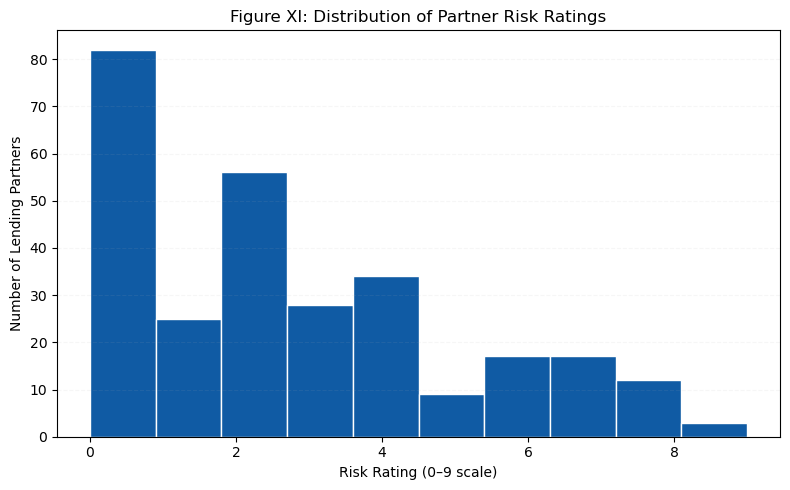

In [600]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
partner_df["Risk Rating"] = partner_df["Risk Rating"].replace("INACTIVE", 0)
partner_df["Risk Rating"] = pd.to_numeric(partner_df["Risk Rating"], errors='coerce')
partner_df["Risk Rating"].dropna().astype(int).plot.hist(bins=10, color="#105ba4", edgecolor="white")
plt.title("Figure XI: Distribution of Partner Risk Ratings")
plt.xlabel("Risk Rating (0–9 scale)")
plt.ylabel("Number of Lending Partners")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

Figure XI presents the distribution of partner risk ratings for all 283 lending partners scraped from Kiva’s public directory. The ratings are on a 0–9 scale, where higher values indicate greater financial reliability. The distribution is heavily right-skewed, with the most common rating being 0, either due to partners marked as "INACTIVE", or unrated entities. While some partners achieve ratings as high as 9, relatively few fall into this upper range. This skew suggests a large portion of Kiva’s partners are either too new, too small, or too unknown to have been assigned a formal rating, which may complicate evaluations of institutional quality in microfinance lending.

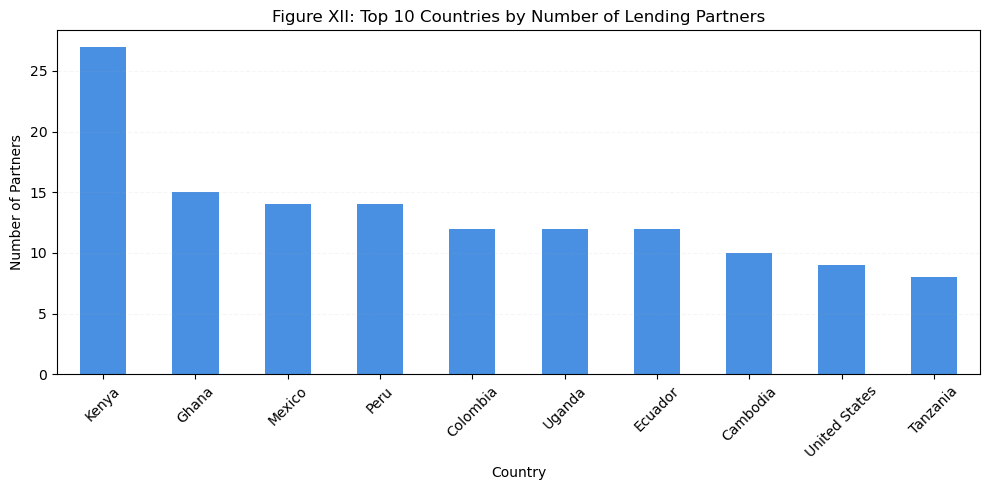

In [605]:
partner_df["Country List"] = partner_df["Country"].str.split(", ")
country_counts = partner_df.explode("Country List")["Country List"].value_counts().head(10)

plt.figure(figsize=(10, 5))
country_counts.plot(kind="bar", color="#4a90e2")
plt.title("Figure XII: Top 10 Countries by Number of Lending Partners")
plt.xlabel("Country")
plt.ylabel("Number of Partners")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

Figure XII displays the top 10 countries by number of lending partners listed on Kiva. Kenya leads by a large margin, followed by Ghana, Mexico, and Peru. Surprisingly, the Philippines, despite accounting for over 20% of all loans in the main dataset, are absent from this list, suggesting that a small number of large scale lending partners may be responsible for the country's high lending volume. Conversely, the United States appears among the top countries by number of partners, even though the main dataset contains virtually no loans from the U.S. This mismatch highlights a disconnect between the presence of lending partners and actual lending activity captured in the dataset, raising questions about the role of partner size, activity levels, or restrictions on loan visibility across regions.

In [610]:
partner_df_clean = partner_df.copy()

partner_df_clean["Risk Rating"] = partner_df_clean["Risk Rating"].replace("INACTIVE", 0)
partner_df_clean["Risk Rating"] = pd.to_numeric(partner_df_clean["Risk Rating"], errors="coerce")
partner_df_clean["Default Rate"] = partner_df_clean["Default Rate"].str.replace("%", "").replace("N/A", pd.NA)
partner_df_clean["Default Rate"] = pd.to_numeric(partner_df_clean["Default Rate"], errors="coerce")
partner_df_clean = partner_df_clean.dropna(subset=["Risk Rating", "Default Rate"])

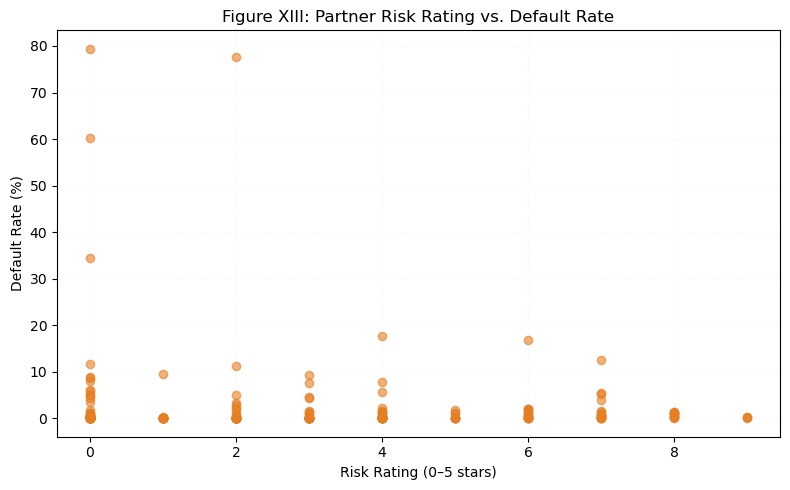

In [618]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(partner_df_clean["Risk Rating"], partner_df_clean["Default Rate"], alpha=0.6, color="#e67e22")
plt.title("Figure XIII: Partner Risk Rating vs. Default Rate")
plt.xlabel("Risk Rating (0–5 stars)")
plt.ylabel("Default Rate (%)")
plt.grid(True, linestyle='--', alpha=0.05)
plt.tight_layout()
plt.show()

Figure XIII explores the relationship between partner risk rating and default rate. While we might expect higher risk partners to exhibit higher default rates, the plot shows no clear correlation between the two metrics. Several institutions with a risk rating of 0 (either unrated or marked inactive) show extreme default rates, including values as high as 70–80%, but these appear to be outliers. Across the rest of the ratings, default rates are fairly scattered and low, suggesting that the assigned partner risk rating may not reliably predict default performance. This raises important questions for Kiva’s internal rating methodology and indicates that additional, maybe qualitative, factors may influence both institutional performance and rating designation.

## 3.2 Machine Learning

To complement the OLS analysis conducted earlier in the paper, this section applies machine learning models, specifically regression trees which then extend to random forests, to explore non-linear patterns and interactions in the predictors of loan sizes on Kiva. While the previous regression assumed a linear relationship between the dependent variable and covariates, regression trees allow for flexible splits and interactions that may reveal heterogeneity in loan allocation that linear models cannot capture.

In a regression tree, the model aims to split the data into distinct and non overlapping regions that minimise the variation of the target variable within each region. The objective function can be written as:

$$
\min_T \sum_{m=1}^{|T|} \sum_{i \in R_m} (y_i - \bar{y}_{R_m})^2 + \alpha |T|
$$

Where:

- $T$ is the set of terminal nodes (leaves) in the tree,
- $|T|$ is the number of leaf nodes (the complexity of the tree),
- $R_m$ is the region (subset of data) assigned to leaf $m$,
- $y_i$ is the observed value of the dependent variable,
- $\bar{y}_{R_m}$ is the mean of $y$ in region $R_m$,
- $\alpha$ is the regularization parameter that penalises large trees.

In our case, the outcome $y_i$ is the loan amount, and the goal is to split the data into subgroups based on values of variables like loan sequence, female dummy, need dummy, etc., in a way that minimises the squared prediction error within each group. It does this by selecting the best variable and threshold at each step that reduces the variance of the target variable. Each split divides the data into two regions where the outcome (loan amount) is more homogeneous. The tree continues to split until a stopping criterion is met, for example a minimum number of samples in a leaf or the maximum depth is reached, thus balancing predictive accuracy with interpretability.

In regression trees, regularisation parameters are important for controlling model complexity and preventing overfitting. The most common regularisation parameters include the maximum depth of the tree, the minimum number of samples required to split a node, and the pruning penalty term, often denoted as $\alpha$, which penalises the number of terminal nodes (or leaves) in the tree. By adjusting this parameter, we can change the internal trade-off between model bias and variance. There is typically an optimal value of the regularisation parameter $\alpha$ that minimises prediction error on unseen data by balancing this trade-off. This optimal value is often found using cross-validation techniques, which allow us to tune the model in a way that generalises well beyond the training sample.

We can start with a simple regression tree model with only borrower level characterstics and interactions, to isolate the effect of individual borrowers on loan amounts. This restricted specification  is:

$$
\begin{aligned}
LoanAmount_{it} &= \alpha + \beta_1 \cdot LoanSeq_{it} + \beta_2 \cdot Female_{it} + \beta_3 \cdot MixedGender_{it} + \beta_4 \cdot NeedLabel_{it} \\
&\quad + \beta_5 \cdot (LoanSeq \times Female)_{it} + \beta_6 \cdot (LoanSeq \times NeedLabel)_{it} \\
&\quad + \beta_7 \cdot Pictured_{it} + \beta_8 \cdot Repeat_{it} + \beta_9 \cdot BorrowerCount_{it} + \varepsilon_{it}
\end{aligned}
$$

Where:

- $\log(LoanAmount_{it})$ is the natural logarithm of the loan amount for borrower $i$ at time $t$
- $LoanSeq_{it}$ is the loan sequence number (e.g., 1st, 2nd, etc.)
- $Female_{it}$ and $MixedGender_{it}$ are borrower gender dummies
- $NeedLabel_{it}$ is a high-need indicator from text analysis
- $LoanSeq \times Female$ and $LoanSeq \times NeedLabel$ are interaction terms
- $Pictured_{it}$ indicates if the borrower has a photo
- $Repeat_{it}$ captures whether the borrower has borrowed before
- $BorrowerCount_{it}$ is the number of borrowers in the loan
- $\varepsilon_{it}$ is the error term

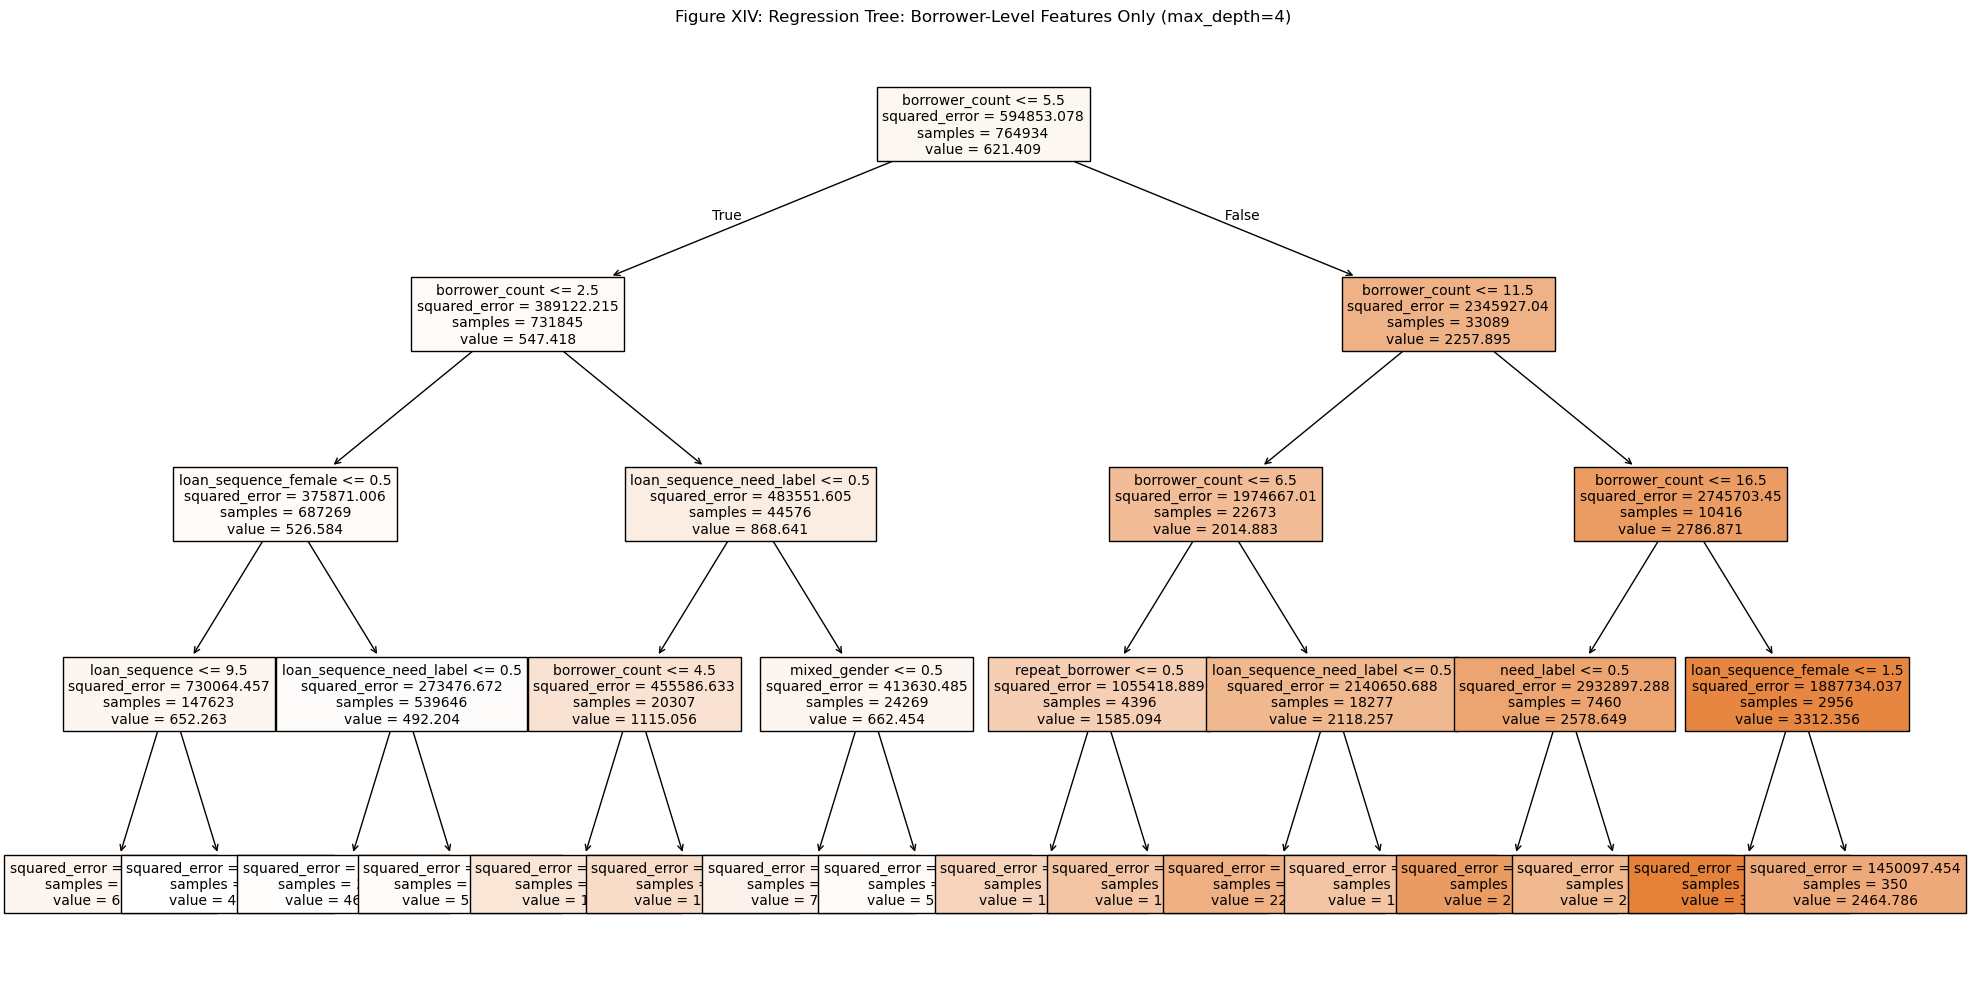

In [753]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Define borrower-level features
borrower_features = [
    'loan_sequence', 'female', 'mixed_gender', 'need_label',
    'borrower_pictured', 'repeat_borrower', 'borrower_count'
]

# Add interaction terms
df['loan_sequence_female'] = df['loan_sequence'] * df['female']
df['loan_sequence_need_label'] = df['loan_sequence'] * df['need_label']
borrower_features += ['loan_sequence_female', 'loan_sequence_need_label']

# Drop missing and prepare data
df_borrower = df[borrower_features + ['loan_amount']].dropna()
X = df_borrower[borrower_features]
y = df_borrower['loan_amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree with fixed depth
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and compute RMSE
y_pred = tree_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # No warnings now

# Plot the tree only
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=borrower_features, filled=True, fontsize=10)
plt.title("Figure XIV: Regression Tree: Borrower-Level Features Only (max_depth=4)")
plt.tight_layout()
plt.show()

The regression tree using only borrower level characteristics (Figure XIV) shows borrower count as the most important initial split, with loans involving fewer borrowers generally associated with lower loan amounts. Other influential features include interaction terms such as loan sequence * female and loan sequence * need label, suggesting that repeat borrowing behaviour interacts with borrower gender and perceived need to shape loan size. Notably, the tree captures substantial heterogeneity in loan outcomes, with some paths predicting values over 3000 and others below 500. However, the RMSE of 722.46 indicates that while the tree captures some non-linear patterns, its predictive performance is still limited, likely due to omitted contextual features such as loan level characteristics or sectoral differences that are excluded from this restricted model.


We can now use the full model from our second regression tree, which is:
$$
\text{LoanAmount}_{it} = \alpha + \beta_1 \text{LoanSeq}_{it} + \mathbf{X}_{it}'\boldsymbol{\gamma} + \mathbf{Z}_{it}'\boldsymbol{\delta} + \boldsymbol{\lambda}_{\text{sector}} + \boldsymbol{\theta}_{\text{country}} + \varepsilon_{it}
$$

Where:
- $\tilde{Y}_{it}$ is the demeaned log loan amount for borrower $i$ at time $t$,
- $\tilde{\text{loan\_sequence}}_{it}$ is the demeaned loan sequence number,
- $\tilde{\text{need\_label}}_{it}$ is the demeaned high-need indicator,
- $\mathbf{\tilde{X}}_{it}$ is a vector of demeaned time-varying control variables (loan term, number of lenders, funding speed),
- $\boldsymbol{\gamma}$ is a vector of coefficients for these controls,
- $\tilde{\epsilon}_{it}$ is the idiosyncratic error term.

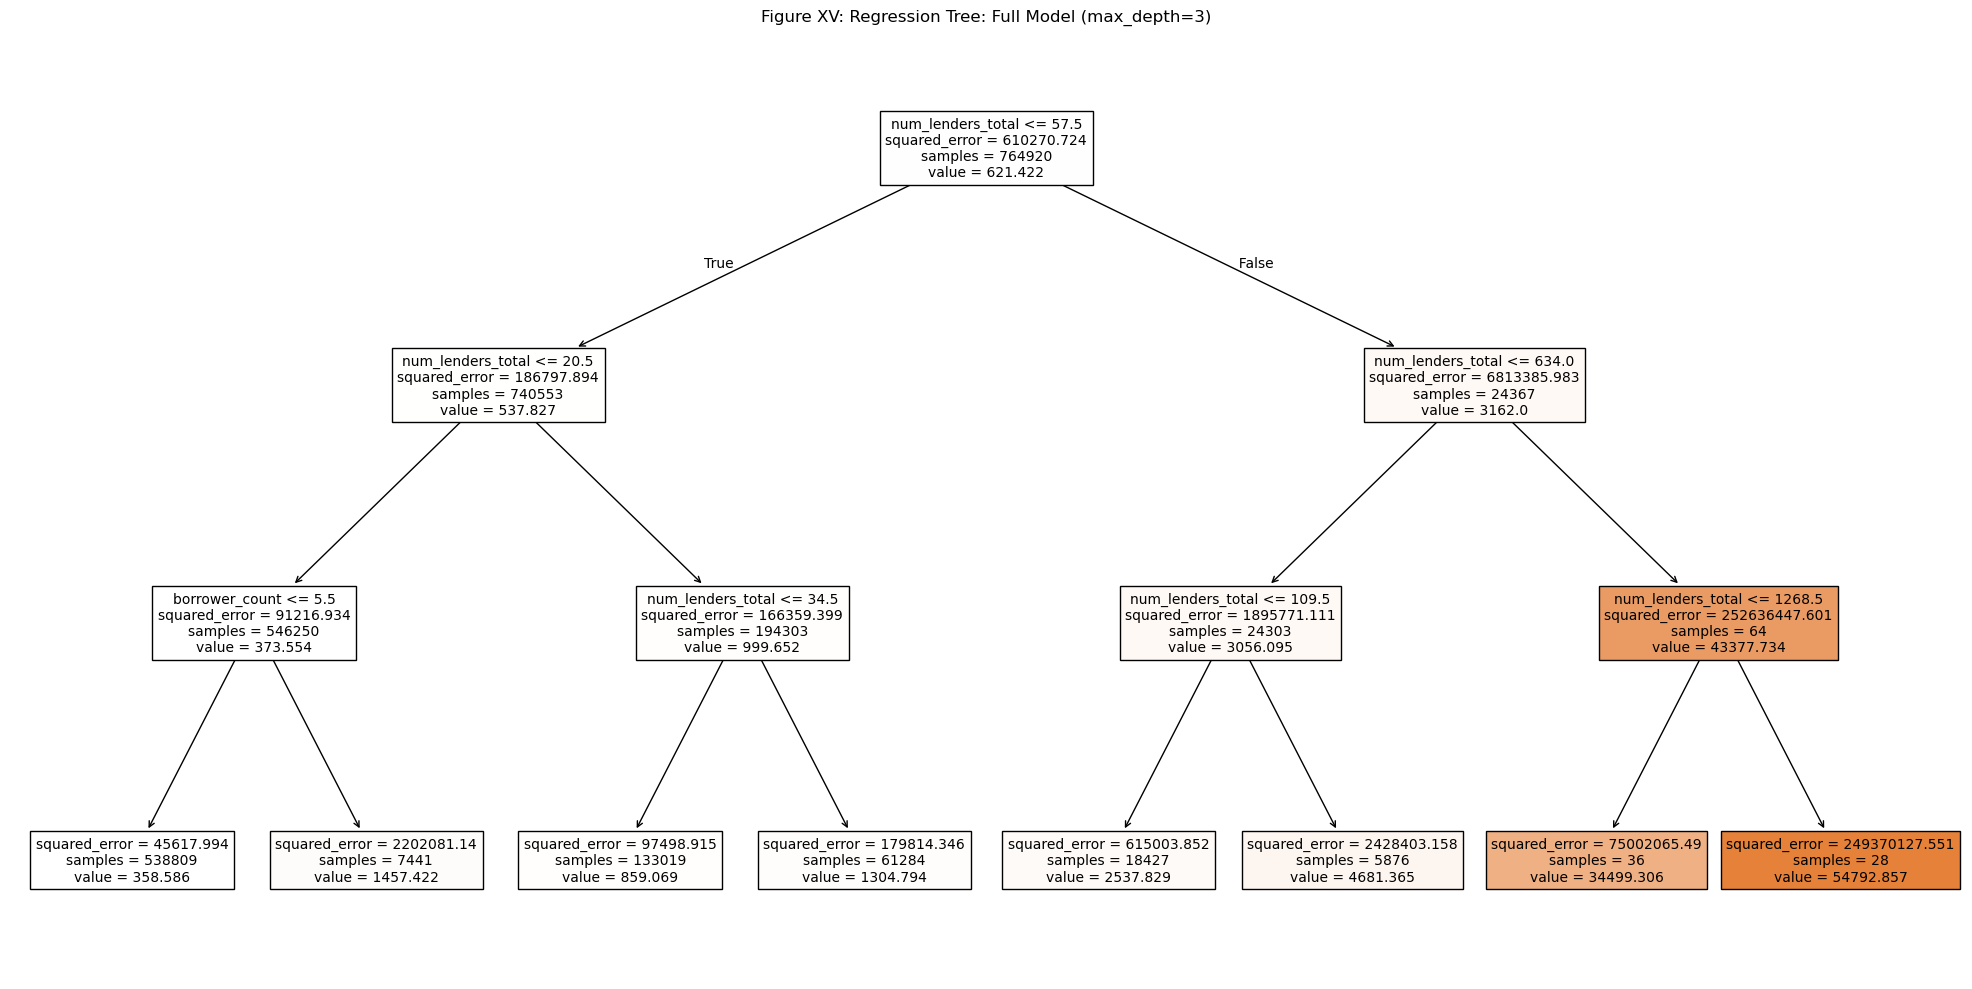

In [761]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Define model variables
features = [
    'loan_sequence', 'female', 'mixed_gender', 'need_label',
    'borrower_pictured', 'repeat_borrower', 'borrower_count',
    'lender_term', 'funding_speed', 'num_lenders_total'
]
target = 'loan_amount'

# Drop missing values and prepare data
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a lightweight tree
tree_model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=20, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and store RMSE
y_pred = tree_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=features, filled=True, fontsize=10)
plt.title("Figure XV: Regression Tree: Full Model (max_depth=3)")
plt.tight_layout()
plt.show()

The second regression tree (Figure XV), which incorporates a broader set of variables including loan level features like number of lenders, funding speed, and lender term, reveals different patterns from the borrower level tree. Notably, number of lenders is consistently the most important variable, driving the top splits in the tree. This suggests that platform level dynamics such as investor demand may play a dominant role in determining loan sizes, beyond borrower characteristics. The model also captures steep jumps in loan size, with certain branches leading to extremely high predicted values (over 54,000), driven by unusually high numbers of lenders. Compared to the first tree, this model captures more of the variance in the data (RMSE of 373.57 vs. 722.46), highlighting the predictive value of including contextual and platform related variables. This shows that while borrower features matter, the broader lending environment and investor participation significantly shape final loan outcomes.

In [768]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import seaborn as sns

# Train the random forest model
forest_model = RandomForestRegressor(
    n_estimators=100,      
    max_depth=6,           
    random_state=42,
    n_jobs=-1              
)
forest_model.fit(X_train, y_train)

# Predict and store RMSE
y_pred_forest = forest_model.predict(X_test)
rmse_forest = root_mean_squared_error(y_test, y_pred_forest)

# Variable importance
importances = pd.DataFrame({
    'Feature': features,
    'Importance': forest_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

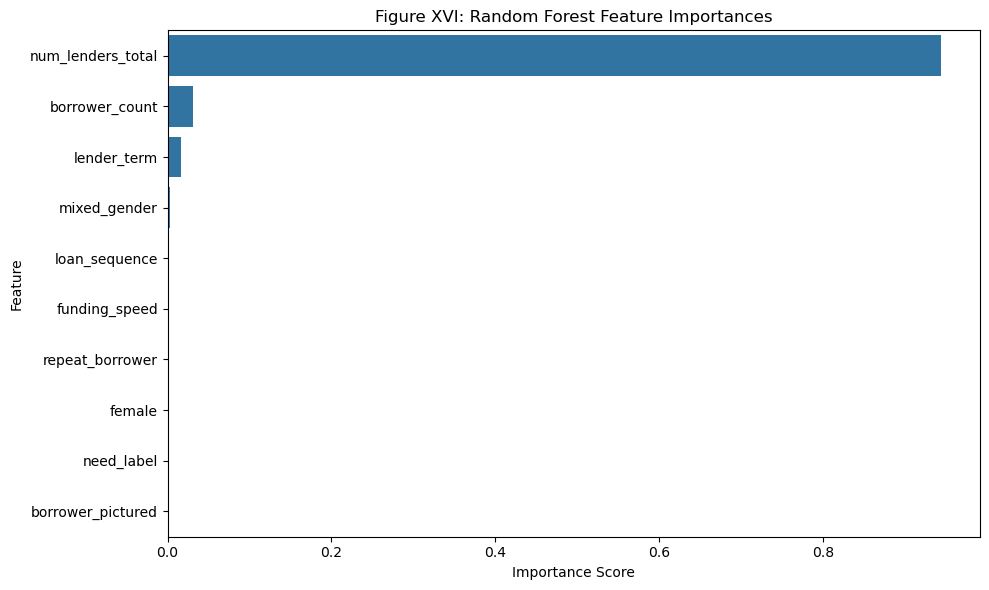

In [782]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title("Figure XVI: Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


The Random Forest importance matrix (Figure XVI) clearly identifies number of lenders as by far the most predictive variable for loan amount, dominating all other features. While the full decision tree (Figure XV) already showed number of lenders as an important splitting criterion, the Random Forest magnifies this importance by averaging over many trees, reinforcing the idea that the number of lenders is a robust and consistent predictor of loan size across various data slices. Other variables such as borrower_count, lender_term, and mixed_gender have minor importance. What is surprising here is the extent to which contextual features like lender activity outperform borrower specific characteristics, highlighting the importance of platform or market driven dynamics in loan determination.

Comparing this to the OLS results, linear regressions assume linear relationships between predictors and the outcome variable. While this provides interpretable coefficients and clear marginal effects, it imposes assumptions that may not align with the actual data generating process, especially when there are nonlinearities or interaction effects. For instance, in our original OLS models, we identified significant interactions like loan sequence * female and loan sequence * need label, suggesting that borrowing behaviour evolves differently by gender or perceived need.

Regression trees, on the other hand, are nonparametric, piecewise constant predictions that can capture threshold effects, interaction structures, and nonlinearities. As seen in Figures XIV and XV, the trees not only identify top predictors (like borrower count or number of lenders) but also map out how their effects vary across subgroups. For example, some splits predict loan amounts below 500 USD, while others exceed 3000 USD, which would be missed by OLS’s uniform slopes.

# 3. Conclusion

This project set out to examine whether microfinance institutions effectively prioritise borrower need in allocating loan amounts, and whether repeated borrowing is associated with growth or dependence. The OLS regressions reveal several important insights. First, while financial vulnerability, measured via a text derived need label and regional poverty index (MPI), is statistically associated with lower absolute loan amounts, high need borrowers tend to receive slightly larger loans relative to income. This suggests some institutional recognition of borrower constraints, though the effect is small and inconsistent across subgroups. Gender disparities also persist: female borrowers and mixed-gender groups consistently receive smaller loans, highlighting a potential equity gap in microloan distribution.

Longitudinal regressions tracking borrowing patterns over time offer further nuance. Individual borrowers generally see a modest increase in loan size across sequential loans, consistent with the notion of relationship lending. However, this growth is significantly slower for borrowers flagged as high-need. In fact, the interaction between loan sequence and need label is negative, implying that even when high-need borrowers return for subsequent loans, they receive smaller increases than their lower-need counterparts. This raises concerns about whether microfinance institutions reinforce dependency rather than enable upward financial mobility, particularly for the very populations they are meant to serve.

The machine learning component adds both value and complexity to the analysis. While the use of a large language model (LLM) to classify need from loan descriptions enabled scalable labeling of over one million loans, this approach introduces classification noise. Some loan descriptions may be mischaracterised due to ambiguity or linguistic subtlety, potentially leading to attenuation bias. For example, if the model misclassifies high-need loans as low-need (or vice versa), the observed relationship between need and loan amount may be underestimated. Despite this limitation, the classifier uncovered clear sectoral trends; high-need loans were concentrated in consumption-oriented sectors like health and housing, while business sectors like retail were dominated by low-need loans.

The regression tree and random forest models, though primarily exploratory, corroborate many of these findings. Borrower-level features such as borrower count, gender, and repeat borrowing status were among the most important variables for predicting loan size. However, these models added limited explanatory power beyond the OLS framework and were less interpretable.

Looking forward, future research could expand this analysis by refining the classification of need, perhaps incorporating multi-label sentiment or urgency detection, or validating labels against external data. Alternatively, a more scalable LLM model could be run on the entire dataset. Further exploration of partner-level factors, such as institutional mission, tenure on Kiva, or risk ratings, could also explore cross-country variation in lending patterns. Finally, more work is needed to understand long-term borrower outcomes. Are repeat loans improving household welfare, or simply sustaining short-term consumption? Linking microfinance data to downstream indicators like business performance, education attainment, or income mobility would provide a fuller picture of microfinance's role in development.

# 4. References

- Alkire, S., & Santos, M. E. (2010). Multidimensional Poverty Index. Oxford Poverty and Human Development Initiative (OPHI).​

- Bangko Sentral ng Pilipinas. (2021). 2021 Financial Inclusion Survey. https://www.bsp.gov.ph/Inclusive%20Finance/Financial%20Inclusion%20Reports%20and%20Publications/2021/2021FISToplineReport.pdf​

- Banerjee, A., Duflo, E., Glennerster, R., & Kinnan, C. (2015). The miracle of microfinance? Evidence from a randomized evaluation. American Economic Journal: Applied Economics, 7(1), 22–53. https://doi.org/10.1257/app.20130533​

- D'Espallier, B., Guérin, I., & Mersland, R. (2011). Women's empowerment and microfinance: A global analysis. Journal of Microfinance, 13(1), 21–49.​

- Domanban, P. B. (2023). Determinants of loan sizes in microfinance institutions: Evidence from the Upper West Region of Ghana. Cogent Economics & Finance, 12(1), 2300924. https://doi.org/10.1080/23322039.2023.2300924​

- Field, E., Pande, R., Papp, J., & Rigol, N. (2013). Does the classic microfinance model discourage entrepreneurship among the poor? Experimental evidence from India. American Economic Review, 103(6), 2196–2226. https://doi.org/10.1257/aer.103.6.2196​

- Food and Agriculture Organization. (2024). Employment indicators 2000–2022 (October 2024 update). https://www.fao.org/statistics/highlights-archive/highlights-detail/employment-indicators-2000-2022-%28september-2024-update%29/en​

- Hermes, N., & Lensink, R. (2011). Microfinance: Its impact, outreach, and sustainability. World Development, 39(6), 875–881. https://doi.org/10.1016/j.worlddev.2009.10.021​

- Huang, Y., Li, X., & Wang, C. (2019). What does peer-to-peer lending evidence say about the risk-taking channel of monetary policy? https://www.cb.cityu.edu.hk/ef/doc/GRU/BOFIT%202019/HLW_WithApp_June2019.pdf​

- Muthoni, P. M., & Lewa, P. M. (2017). Influence of loan characteristics on microcredit default in Kenya: A comparative analysis of microfinance institutions and financial intermediaries. IOSR Journal of Business and Management, 19(5), 39–59. https://doi.org/10.9790/487X-1905043959​

- Sanz-Guerrero, M., & Arroyo, J. (2024). Credit risk meets large language models: Building a risk indicator from loan descriptions in P2P lending. arXiv preprint arXiv:2401.16458.